In [414]:
import logging
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import (GridSearchCV, HalvingGridSearchCV, RandomizedSearchCV,
                                     StratifiedKFold, cross_val_score, learning_curve, validation_curve,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real
from umap import UMAP
import optuna

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [415]:
RANDOM_STATE = 0

In [416]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook")

In [417]:
df = pd.read_csv('mldata_0003157425.csv')

## EDA

In [418]:
# Display basic information
print("\n--- Dataset Head ---")
print(df.head())

print(f"\n--- Dataset Shape ---")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print(f"\n--- Dataset Info ---")
df.info()

print(f"\n--- Missing Values ---")
print(df.isnull().sum().sum()) # Total missing values


--- Dataset Head ---
   Unnamed: 0  label  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  feature_13  feature_14  feature_15  \
0           0      2   1.394040  -0.560729  -2.683595  -0.979726  -0.465095  -8.530843  -0.307211   0.338850  -0.049992    0.430564   -0.557336   -0.083499    1.382397    1.847391    1.742409   
1           1      2   0.945826   2.013913   0.560470  -0.960273  -0.770016   5.876345  -0.377342   0.048879   0.897209    0.224006    1.829282   -5.589760   -0.684027    2.064995    0.271522   
2           2      0   1.030214   0.235589  -0.222638  -0.116798  -0.985745  -4.585816   0.463274  -0.571512  -0.222067   -0.913908    0.730195    1.775106   -0.269479   -4.679246    0.719859   
3           3      1  -0.304264   0.550437   2.529918   0.164535  -1.013062  -0.590612  -0.339393  -0.189251   0.572885   -0.015524   -0.924212    1.476168    0.860342   -1.398179   -2.597452   
4  

In [419]:
sample_ids = df.index.tolist() # Store sample IDs for later use
X = df.drop(columns=['label', 'Unnamed: 0'])
y = df['label']
feature_names = X.columns.tolist()

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of unique labels: {y.nunique()}")
print(f"Label values: {np.sort(y.unique())}")


Features shape: (1000, 35)
Target shape: (1000,)
Number of unique labels: 3
Label values: [0 1 2]


In [420]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

# Using nested cross-validation to evaluate the model, so we don't need to split the data again
X_train_val = X
y_train_val = y

print(f"\nShape of X_train_val: {X_train_val.shape}")
print(f"Shape of y_train_val: {y_train_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

print("\nLabel distribution in original dataset:")
print(y.value_counts(normalize=True).sort_index())

print("\nLabel distribution in training/validation set:")
print(y_train_val.value_counts(normalize=True).sort_index())

print("\nLabel distribution in test set:")
print(y_test.value_counts(normalize=True).sort_index())


Shape of X_train_val: (1000, 35)
Shape of y_train_val: (1000,)
Shape of X_test: (200, 35)
Shape of y_test: (200,)

Label distribution in original dataset:
label
0    0.343
1    0.325
2    0.332
Name: proportion, dtype: float64

Label distribution in training/validation set:
label
0    0.343
1    0.325
2    0.332
Name: proportion, dtype: float64

Label distribution in test set:
label
0    0.345
1    0.325
2    0.330
Name: proportion, dtype: float64



--- Summary Statistics for Features (X_train_val) ---
             count      mean       std        min       25%       50%       75%        max
feature_1   1000.0  0.077874  0.989825  -3.100383 -0.534935  0.089912  0.726311   2.755302
feature_2   1000.0  0.171867  2.312119  -6.037153 -1.328051  0.235152  1.759064   7.256787
feature_3   1000.0  0.469450  2.437966  -6.977600 -1.150196  0.554915  2.187513   7.342996
feature_4   1000.0 -0.017442  2.663865  -7.622472 -1.861193 -0.166811  1.599934  10.869010
feature_5   1000.0  0.108823  1.002360  -3.444091 -0.569750  0.136728  0.730868   3.576346
feature_6   1000.0  1.123164  5.663782 -20.949578 -2.594140  1.046486  4.859109  19.382189
feature_7   1000.0  0.081289  1.002398  -2.762513 -0.546485  0.061618  0.716482   3.747522
feature_8   1000.0  0.110151  0.980595  -2.866087 -0.562092  0.108780  0.748904   3.770057
feature_9   1000.0  0.136127  1.029954  -3.419866 -0.548197  0.188460  0.849775   3.673113
feature_10  1000.0  0.124670  1.029

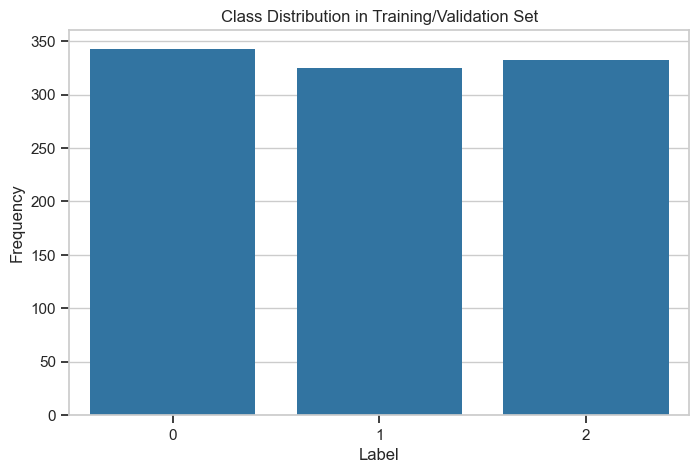

In [421]:
print("\n--- Summary Statistics for Features (X_train_val) ---")
print(X_train_val.describe().T)

plt.figure(figsize=(8, 5))
sns.countplot(x=y_train_val)
plt.title('Class Distribution in Training/Validation Set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

### Feature Distributions

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 24))
axes = axes.flatten()

for i, col in enumerate(X_train_val.columns[:35]):
    sns.histplot(X_train_val[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency')

# Nascondi eventuali assi inutilizzati (in caso meno di 35 feature)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Feature Boxplots

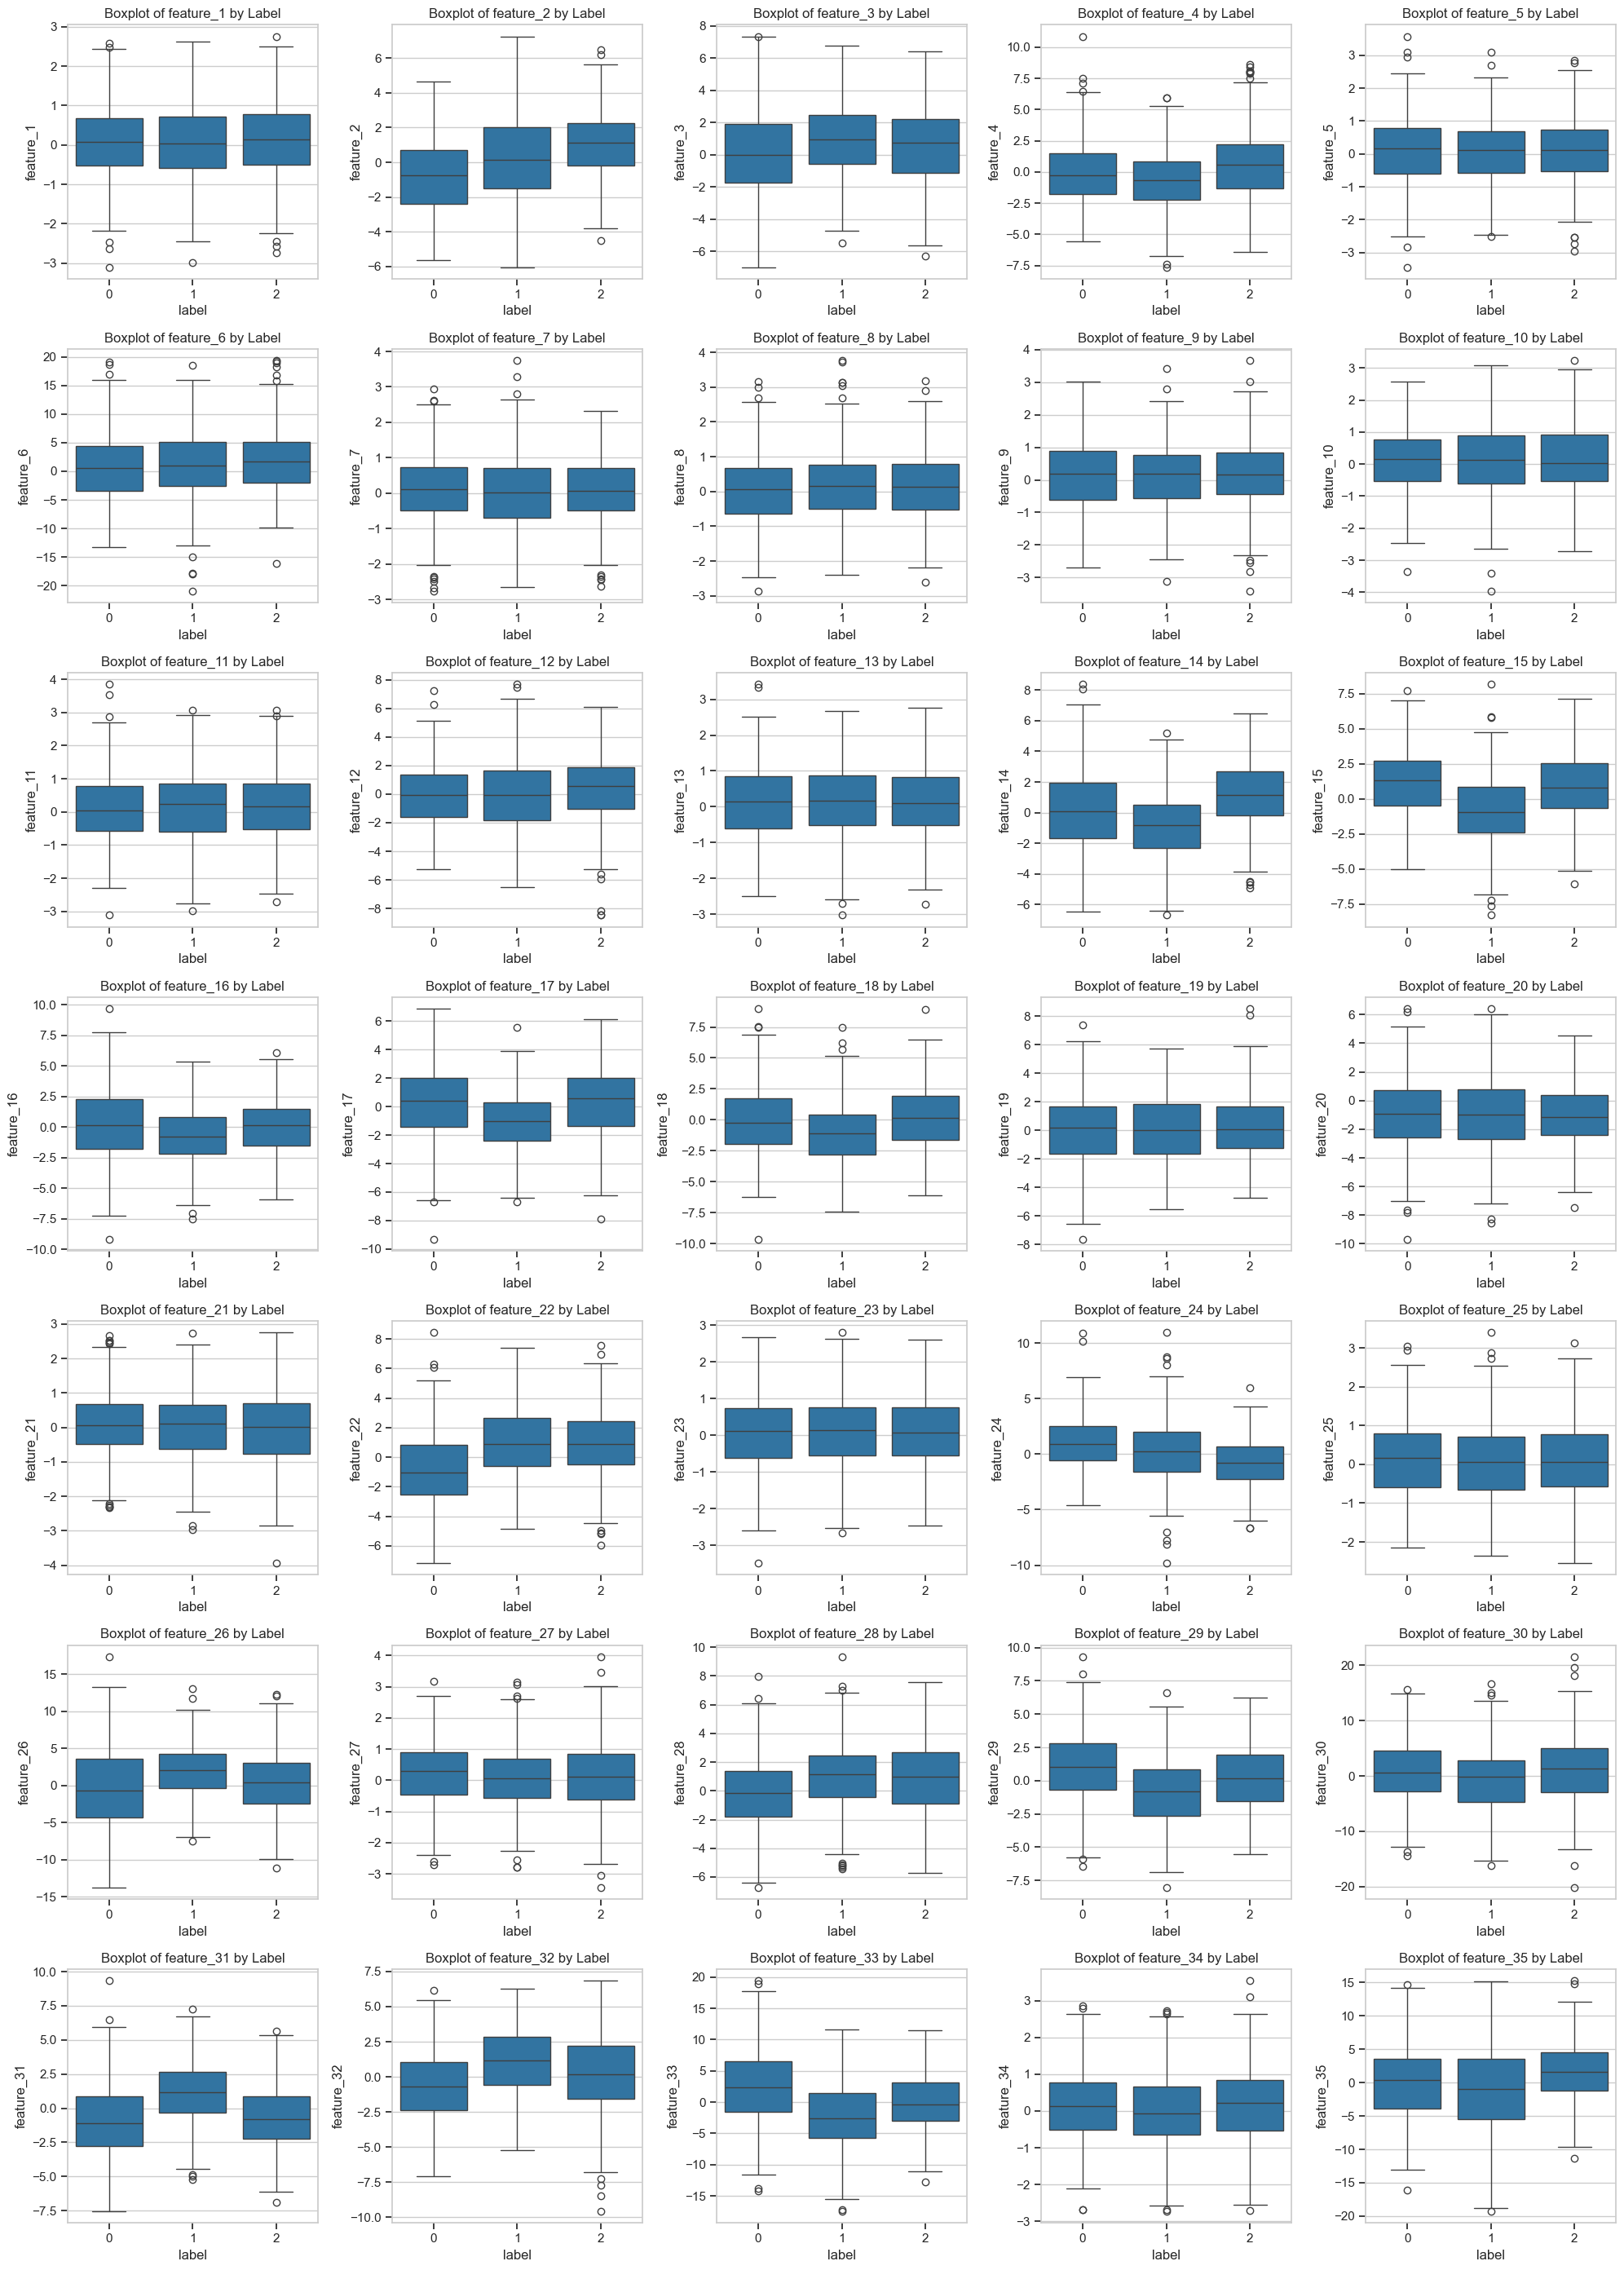

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 28))
axes = axes.flatten()

temp_df = X_train_val.iloc[:, :35].copy()
temp_df['label'] = y_train_val.values

for i, col in enumerate(temp_df.columns[:-1]):
    sns.boxplot(x='label', y=col, data=temp_df, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} by Label')

# Nascondi eventuali assi inutilizzati
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Correlation between variables


--- Correlation Matrix of Features ---


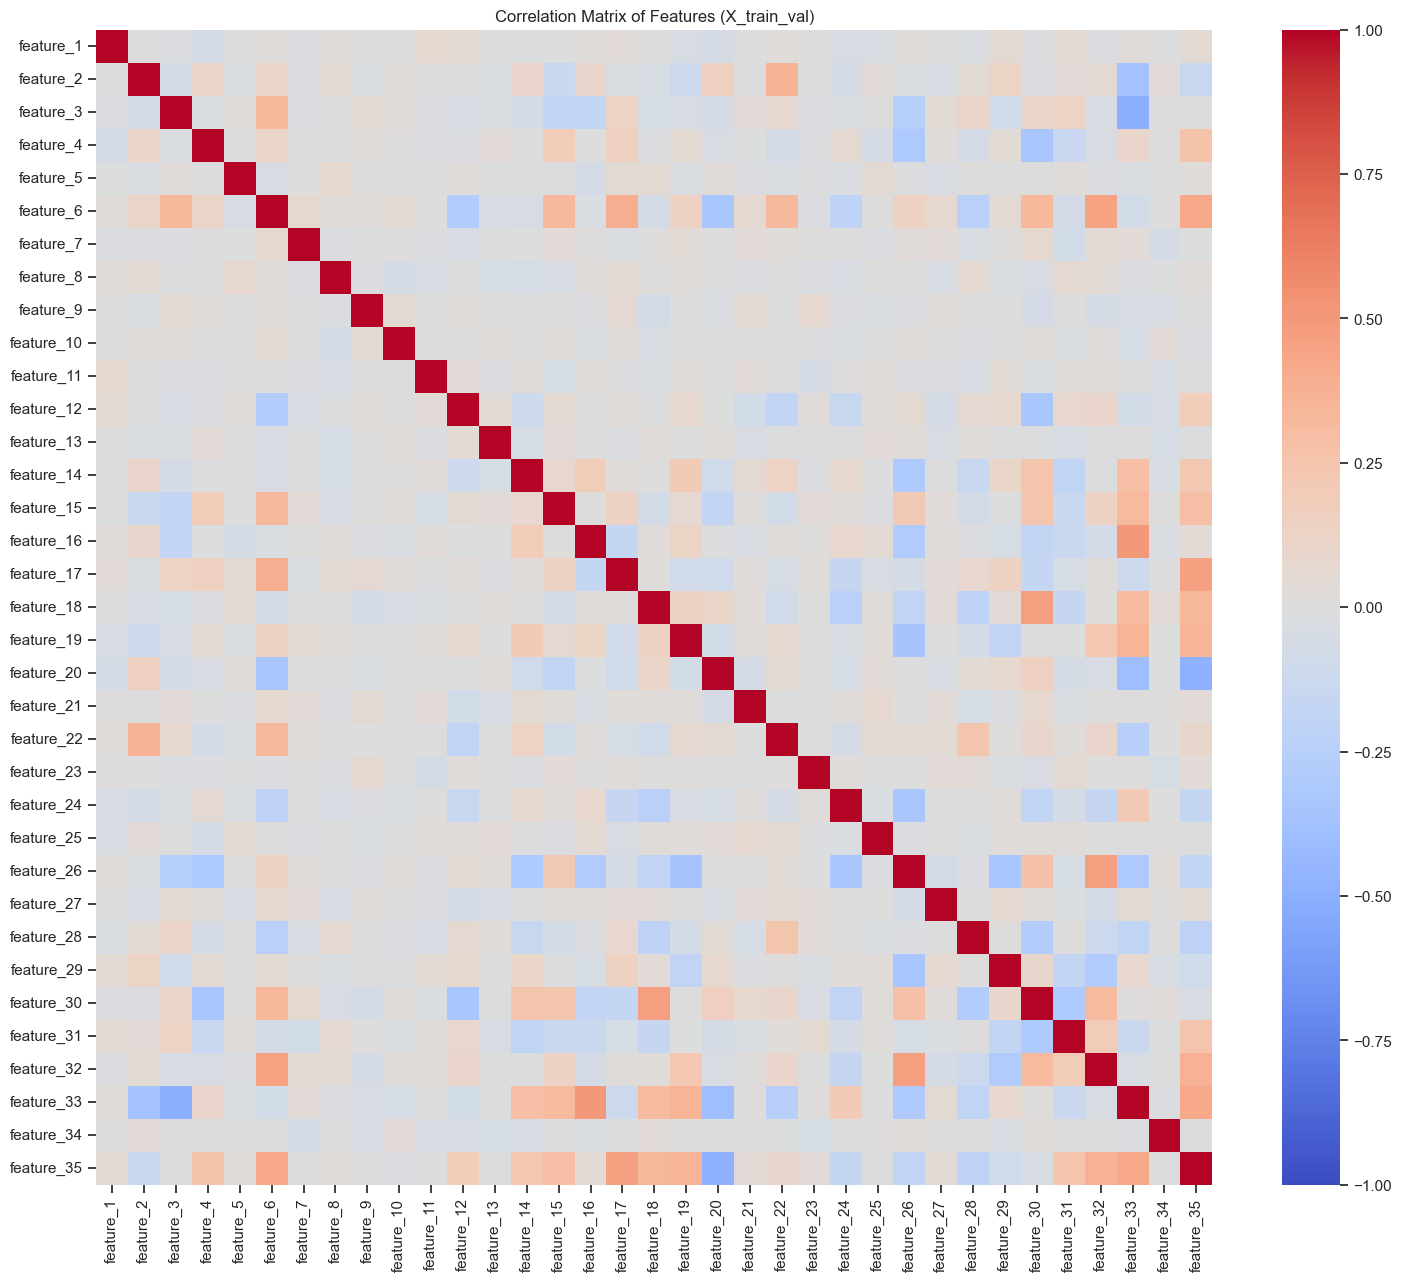


No feature pairs with absolute correlation > 0.8 found.


In [ ]:
print("\n--- Correlation Matrix of Features ---")
correlation_matrix = X_train_val.corr()
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features (X_train_val)')
plt.show()

upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_features = [(column, upper[column].abs().sort_values(ascending=False).index[0], upper[column].abs().sort_values(ascending=False).iloc[0])
                              for column in upper.columns if upper[column].abs().max() > 0.8]
if highly_correlated_features:
    print("\nHighly correlated feature pairs (absolute correlation > 0.8):")
    for f1, f2, corr_val in highly_correlated_features:
        print(f"{f1} and {f2}: {corr_val:.2f}")
else:
    print("\nNo feature pairs with absolute correlation > 0.8 found.")

### T-SNE and UMAP Visualization

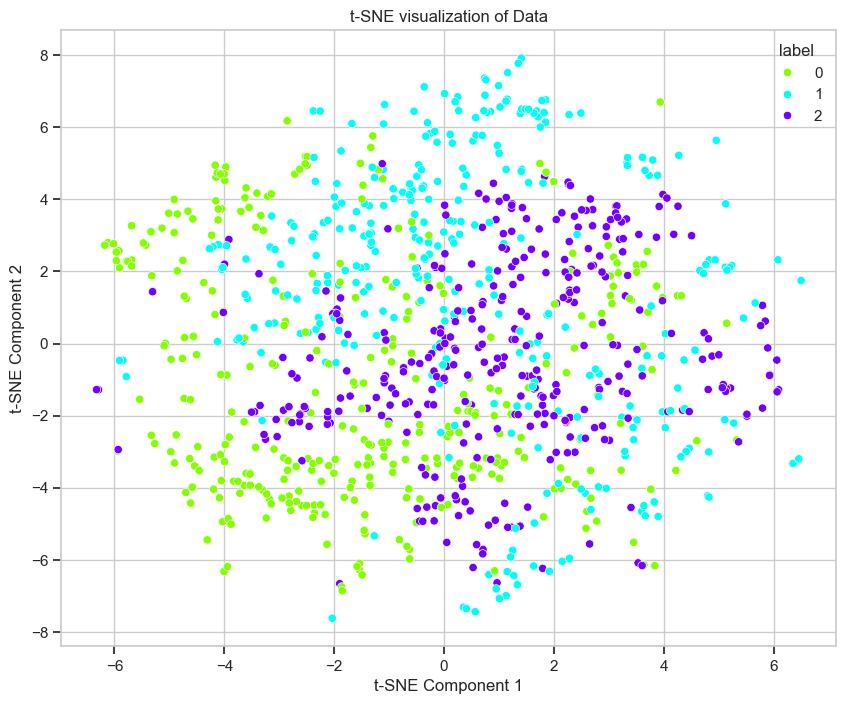

In [ ]:
scaler_eda = StandardScaler()
X_train_val_scaled_eda = scaler_eda.fit_transform(X_train_val)

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_train_val_scaled_eda)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_train_val, palette=sns.color_palette("hsv", n_colors=y.nunique()), legend="full")
plt.title('t-SNE visualization of Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


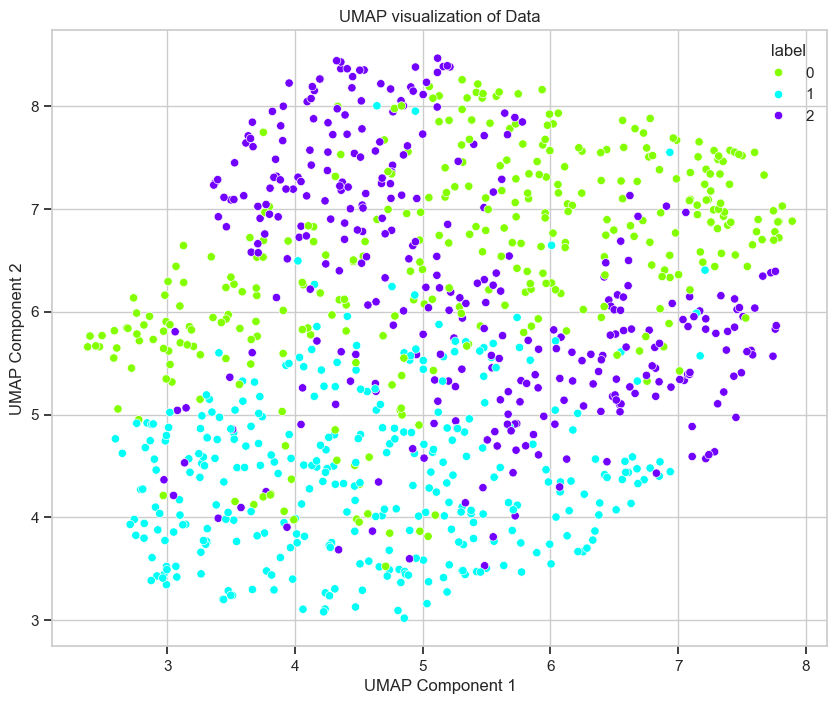

In [ ]:
reducer = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=RANDOM_STATE)
X_umap = reducer.fit_transform(X_train_val_scaled_eda)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y_train_val, palette=sns.color_palette("hsv", n_colors=y.nunique()), legend="full")
plt.title('UMAP visualization of Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

## Hyperparameter Tuning

In [ ]:
N_CV_OUTER = 5  # Number of folds for outer cross-validation (evaluation)
N_CV_INNER = 3  # Number of folds for inner cross-validation (hyperparameter tuning)
N_ITER_RANDOM = 50 # Number of iterations for RandomizedSearchCV and BayesSearchCV
N_TRIALS_OPTUNA = 50 # Number of trials for Optuna

In [ ]:
# Cross validation strategy
cv_outer = StratifiedKFold(n_splits=N_CV_OUTER, shuffle=True, random_state=RANDOM_STATE)
cv_inner = StratifiedKFold(n_splits=N_CV_INNER, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
def plot_validation_curve(estimator, param_name, param_range, X, y, cv, scoring='accuracy'):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=-1
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    if np.issubdtype(np.array(param_range).dtype, np.number) and \
       (np.max(param_range) / np.min(param_range) > 10 if np.min(param_range) > 0 else False) : # Crude check for log scale
        plt.semilogx(param_range, train_scores_mean, label='Training score', marker='o')
        plt.semilogx(param_range, test_scores_mean, label='Cross-validation score', marker='o')
    else:
        plt.plot(param_range, train_scores_mean, label='Training score', marker='o')
        plt.plot(param_range, test_scores_mean, label='Cross-validation score', marker='o')
    
    plt.title(f'Validation Curve for {estimator.steps[-1][0]}: {param_name.split("__")[-1]}')
    plt.xlabel(f'{param_name.split("__")[-1]}')
    plt.ylabel(scoring.capitalize())
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

def plot_learning_curve_custom(estimator, X, y, cv, scoring='accuracy'):
    train_sizes = np.linspace(0.1, 1.0, 5)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1, train_sizes=train_sizes, random_state=RANDOM_STATE
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.title(f'Learning Curve for {estimator.steps[-1][0] if hasattr(estimator, "steps") else estimator.__class__.__name__}')
    plt.xlabel("Training examples")
    plt.ylabel(scoring.capitalize())
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

def compare_validation_curves(estimator1, estimator2, name1, name2, 
                              param1_name, param1_range, 
                              param2_name, param2_range,
                              X, y, cv, scoring='accuracy'):
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    for ax, estimator, name, param_name, param_range in zip(
        axes, [estimator1, estimator2], [name1, name2], [param1_name, param2_name], [param1_range, param2_range]):
        
        train_scores, test_scores = validation_curve(
            estimator, X, y, param_name=param_name, param_range=param_range,
            cv=cv, scoring=scoring, n_jobs=-1
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        if np.issubdtype(np.array(param_range).dtype, np.number) and \
           (np.max(param_range) / np.min(param_range) > 10 if np.min(param_range) > 0 else False):
            ax.semilogx(param_range, train_scores_mean, label='Training score', marker='o')
            ax.semilogx(param_range, test_scores_mean, label='Cross-validation score', marker='o')
        else:
            ax.plot(param_range, train_scores_mean, label='Training score', marker='o')
            ax.plot(param_range, test_scores_mean, label='Cross-validation score', marker='o')

        ax.set_title(f'Validation Curve: {name}\n{param_name.split("__")[-1]}')
        ax.set_xlabel(param_name.split("__")[-1])
        ax.set_ylabel(scoring.capitalize())
        ax.grid(True)
        ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

def compare_learning_curves(estimator1, estimator2, name1, name2, X, y, cv, scoring='accuracy'):
    train_sizes = np.linspace(0.1, 1.0, 5)

    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    for ax, estimator, name in zip(axes, [estimator1, estimator2], [name1, name2]):
        train_sizes_i, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1, train_sizes=train_sizes, random_state=RANDOM_STATE
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        ax.plot(train_sizes_i, train_scores_mean, 'o-', color='r', label='Training score')
        ax.plot(train_sizes_i, test_scores_mean, 'o-', color='g', label='Cross-validation score')
        ax.fill_between(train_sizes_i, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color='r')
        ax.fill_between(train_sizes_i, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color='g')
        ax.set_title(f'Learning Curve: {name}')
        ax.set_xlabel("Training examples")
        ax.set_ylabel(scoring.capitalize())
        ax.grid(True)
        ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

In [ ]:
results_summary = [] # To store (model_name, strategy_name, time, candidates, mean_score, std_score)

# Common Scaler
scaler = StandardScaler()

# k-Nearest Neighbors (kNN)
knn_pipeline = Pipeline([
    ('scaler', scaler),
    ('knn', KNeighborsClassifier())
])

# kNN Parameter Grid/Spaces
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 15, 21, 25, 29],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
    'knn__p': [1, 2] # Relevant for minkowski
}
# For skopt (BayesSearchCV)
knn_search_spaces_skopt = {
    'knn__n_neighbors': Integer(3, 29),
    'knn__weights': Categorical(['uniform', 'distance']),
    'knn__metric': Categorical(['euclidean', 'manhattan', 'minkowski']),
    'knn__p': Integer(1,2) # if metric is minkowski
}

# --- Logistic Regression ---
logreg_pipeline = Pipeline([
    ('scaler', scaler),
    ('logreg', LogisticRegression(solver='liblinear', max_iter=100000, random_state=RANDOM_STATE)) # No multi_class, solver specified
])

# Logistic Regression Parameter Grid/Spaces
logreg_param_grid = {
    'logreg__C': np.logspace(-4, 4, 9), # 10^-4 to 10^4
    'logreg__penalty': ['l1', 'l2'],
    'logreg__max_iter': [10000],
    'logreg__solver': ['liblinear', 'saga',      # compatible with both l1 & l2
                    'lbfgs', 'sag', 'newton-cg']  # for penalty='l2'
    # solver is fixed to 'liblinear' in pipeline for L1/L2 compatibility
}
# For skopt (BayesSearchCV)
logreg_search_spaces_skopt = {
    'logreg__C': Real(1e-4, 1e4, prior='log-uniform'),
    'logreg__penalty': Categorical(['l1', 'l2'])
}

### Baseline Model

In [ ]:
start_time = time.perf_counter()
baseline_knn_scores = cross_val_score(knn_pipeline, X_train_val, y_train_val, cv=cv_outer, scoring='accuracy', n_jobs=-1)
time_taken = time.perf_counter() - start_time
results_summary.append({
    'model': 'kNN', 'strategy': 'Baseline', 'time': time_taken, 'candidates': 1,
    'mean_score': np.mean(baseline_knn_scores), 'std_score': np.std(baseline_knn_scores), 'best_params': 'default'
})
print(f"kNN Baseline: Mean Acc={np.mean(baseline_knn_scores):.4f} +/- {np.std(baseline_knn_scores):.4f}, Time={time_taken:.2f}s")


kNN Baseline: Mean Acc=0.7710 +/- 0.0387, Time=1.12s


In [ ]:
start_time = time.perf_counter()
baseline_logreg_scores = cross_val_score(logreg_pipeline, X_train_val, y_train_val, cv=cv_outer, scoring='accuracy', n_jobs=-1)
time_taken = time.perf_counter() - start_time
results_summary.append({
    'model': 'LogReg', 'strategy': 'Baseline', 'time': time_taken, 'candidates': 1,
    'mean_score': np.mean(baseline_logreg_scores), 'std_score': np.std(baseline_logreg_scores), 'best_params': 'default'
})
print(f"LogReg Baseline: Mean Acc={np.mean(baseline_logreg_scores):.4f} +/- {np.std(baseline_logreg_scores):.4f}, Time={time_taken:.2f}s")


LogReg Baseline: Mean Acc=0.7010 +/- 0.0252, Time=0.51s


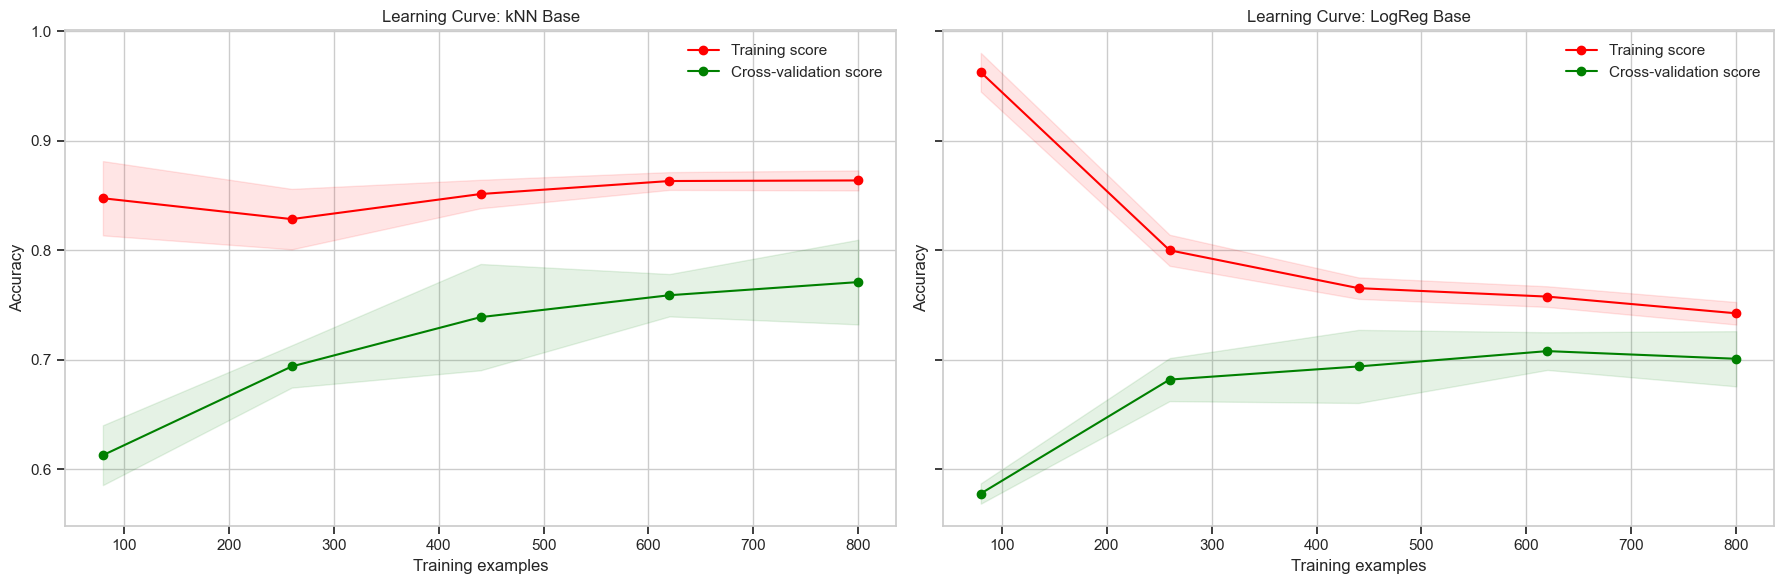

In [ ]:
compare_learning_curves(knn_pipeline, logreg_pipeline, 'kNN Base', 'LogReg Base', X_train_val, y_train_val, cv_outer)

### Grid Search

In [ ]:
grid_search_knn = GridSearchCV(knn_pipeline, knn_param_grid, cv=cv_inner, scoring='accuracy', n_jobs=-1)
start_time = time.perf_counter()
grid_search_knn.fit(X_train_val, y_train_val)
time_taken = time.perf_counter() - start_time
n_candidates_grid = np.prod([len(v) for v in knn_param_grid.values()]) * N_CV_INNER
results_summary.append({
    'model': 'kNN', 'strategy': 'GridSearchCV', 'time': time_taken, 'candidates': n_candidates_grid,
    'mean_score': grid_search_knn.best_score_, 'std_score': grid_search_knn.cv_results_['std_test_score'][grid_search_knn.best_index_],
    'best_params': grid_search_knn.best_params_
})
print(f"kNN GridSearchCV: Best Acc={grid_search_knn.best_score_:.4f}, Time={time_taken:.2f}s, Params={grid_search_knn.best_params_}")

kNN GridSearchCV: Best Acc=0.8180, Time=0.71s, Params={'knn__metric': 'manhattan', 'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'uniform'}


In [ ]:
grid_search_logreg = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=cv_inner, scoring='accuracy', n_jobs=-1)
start_time = time.perf_counter()
grid_search_logreg.fit(X_train_val, y_train_val)
time_taken = time.perf_counter() - start_time
n_candidates_grid_logreg = np.prod([len(v) for v in logreg_param_grid.values()]) * N_CV_INNER
results_summary.append({
    'model': 'LogReg', 'strategy': 'GridSearchCV', 'time': time_taken, 'candidates': n_candidates_grid_logreg,
    'mean_score': grid_search_logreg.best_score_, 'std_score': grid_search_logreg.cv_results_['std_test_score'][grid_search_logreg.best_index_],
    'best_params': grid_search_logreg.best_params_
})
print(f"LogReg GridSearchCV: Best Acc={grid_search_logreg.best_score_:.4f}, Time={time_taken:.2f}s, Params={grid_search_logreg.best_params_}")

LogReg GridSearchCV: Best Acc=0.7140, Time=3.26s, Params={'logreg__C': np.float64(0.1), 'logreg__max_iter': 10000, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}


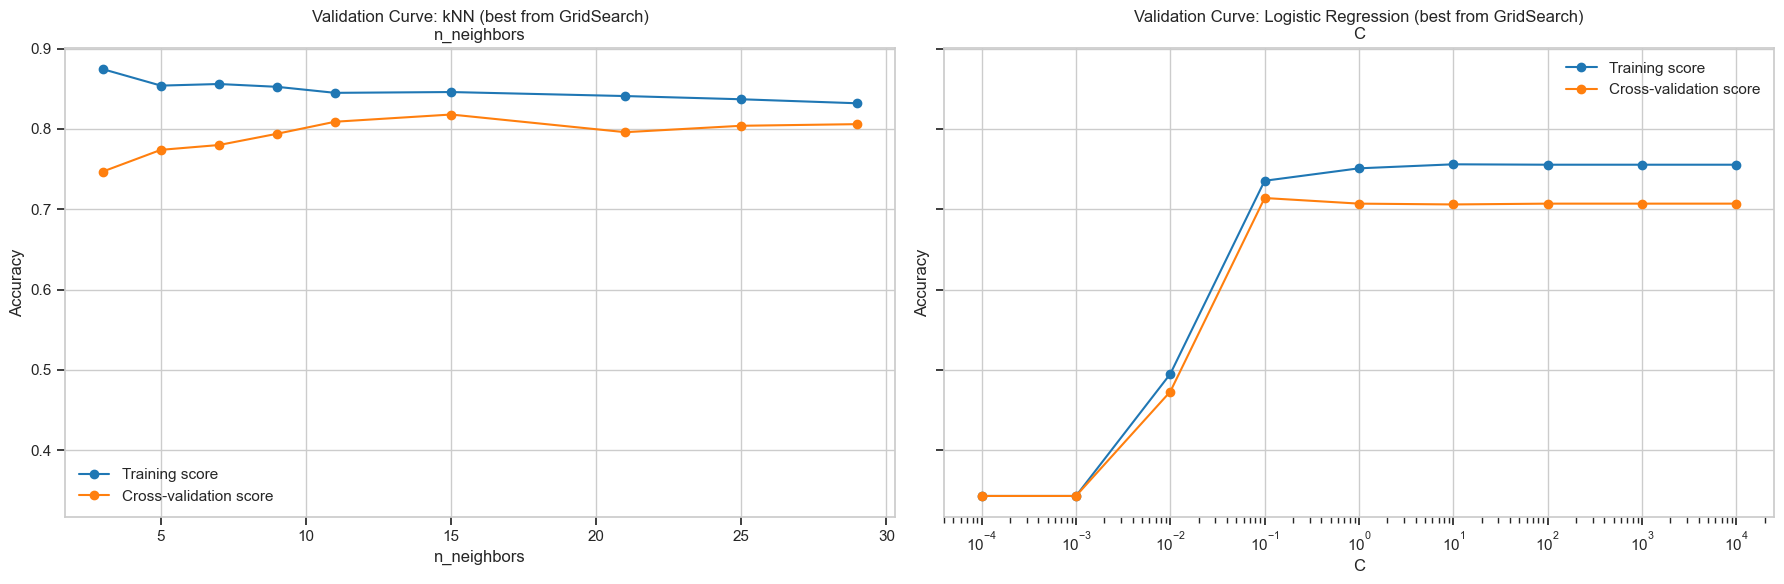

In [ ]:
compare_validation_curves(
    grid_search_knn.best_estimator_, grid_search_logreg.best_estimator_,
    'kNN (best from GridSearch)', 'Logistic Regression (best from GridSearch)',
    'knn__n_neighbors', knn_param_grid['knn__n_neighbors'],
    'logreg__C', logreg_param_grid['logreg__C'],
    X_train_val, y_train_val, cv=cv_inner
)


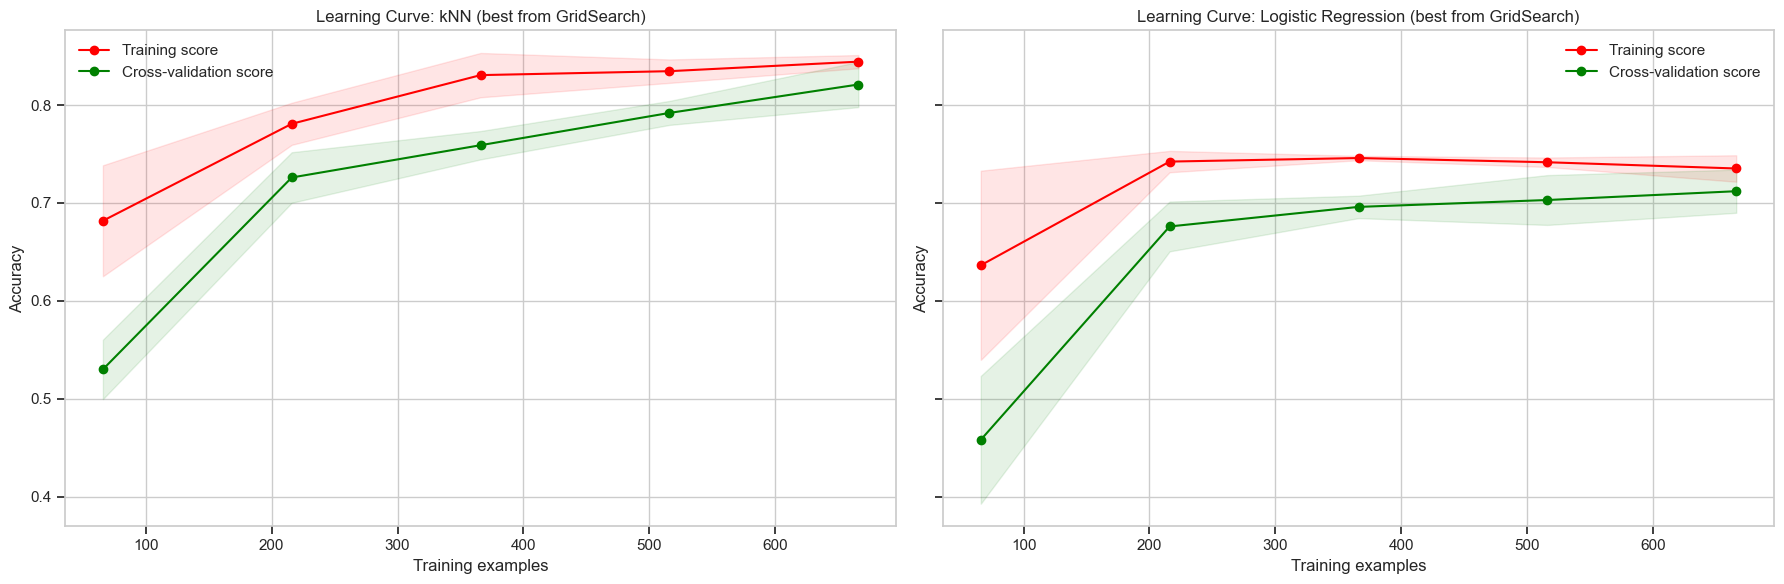

In [ ]:
compare_learning_curves(
    grid_search_knn.best_estimator_, grid_search_logreg.best_estimator_,
    'kNN (best from GridSearch)', 'Logistic Regression (best from GridSearch)',
    X_train_val, y_train_val, cv=cv_inner
)


### Randomized Search

In [ ]:
random_search_knn = RandomizedSearchCV(knn_pipeline, knn_param_grid, n_iter=N_ITER_RANDOM,
                                       cv=cv_inner, scoring='accuracy', random_state=RANDOM_STATE, n_jobs=-1)
start_time = time.perf_counter()
random_search_knn.fit(X_train_val, y_train_val)
time_taken = time.perf_counter() - start_time
results_summary.append({
    'model': 'kNN', 'strategy': 'RandomizedSearchCV', 'time': time_taken, 'candidates': N_ITER_RANDOM * N_CV_INNER,
    'mean_score': random_search_knn.best_score_, 'std_score': random_search_knn.cv_results_['std_test_score'][random_search_knn.best_index_],
    'best_params': random_search_knn.best_params_
})
print(f"kNN RandomizedSearchCV: Best Acc={random_search_knn.best_score_:.4f}, Time={time_taken:.2f}s, Params={random_search_knn.best_params_}")

kNN RandomizedSearchCV: Best Acc=0.8170, Time=0.25s, Params={'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 15, 'knn__metric': 'minkowski'}


In [ ]:
random_search_logreg = RandomizedSearchCV(logreg_pipeline, logreg_param_grid, n_iter=N_ITER_RANDOM,
                                          cv=cv_inner, scoring='accuracy', random_state=RANDOM_STATE, n_jobs=-1)
start_time = time.perf_counter()
random_search_logreg.fit(X_train_val, y_train_val)
time_taken = time.perf_counter() - start_time
results_summary.append({
    'model': 'LogReg', 'strategy': 'RandomizedSearchCV', 'time': time_taken, 'candidates': N_ITER_RANDOM * N_CV_INNER,
    'mean_score': random_search_logreg.best_score_, 'std_score': random_search_logreg.cv_results_['std_test_score'][random_search_logreg.best_index_],
    'best_params': random_search_logreg.best_params_
})
print(f"LogReg RandomizedSearchCV: Best Acc={random_search_logreg.best_score_:.4f}, Time={time_taken:.2f}s, Params={random_search_logreg.best_params_}")

LogReg RandomizedSearchCV: Best Acc=0.7110, Time=1.85s, Params={'logreg__solver': 'liblinear', 'logreg__penalty': 'l1', 'logreg__max_iter': 10000, 'logreg__C': np.float64(0.1)}


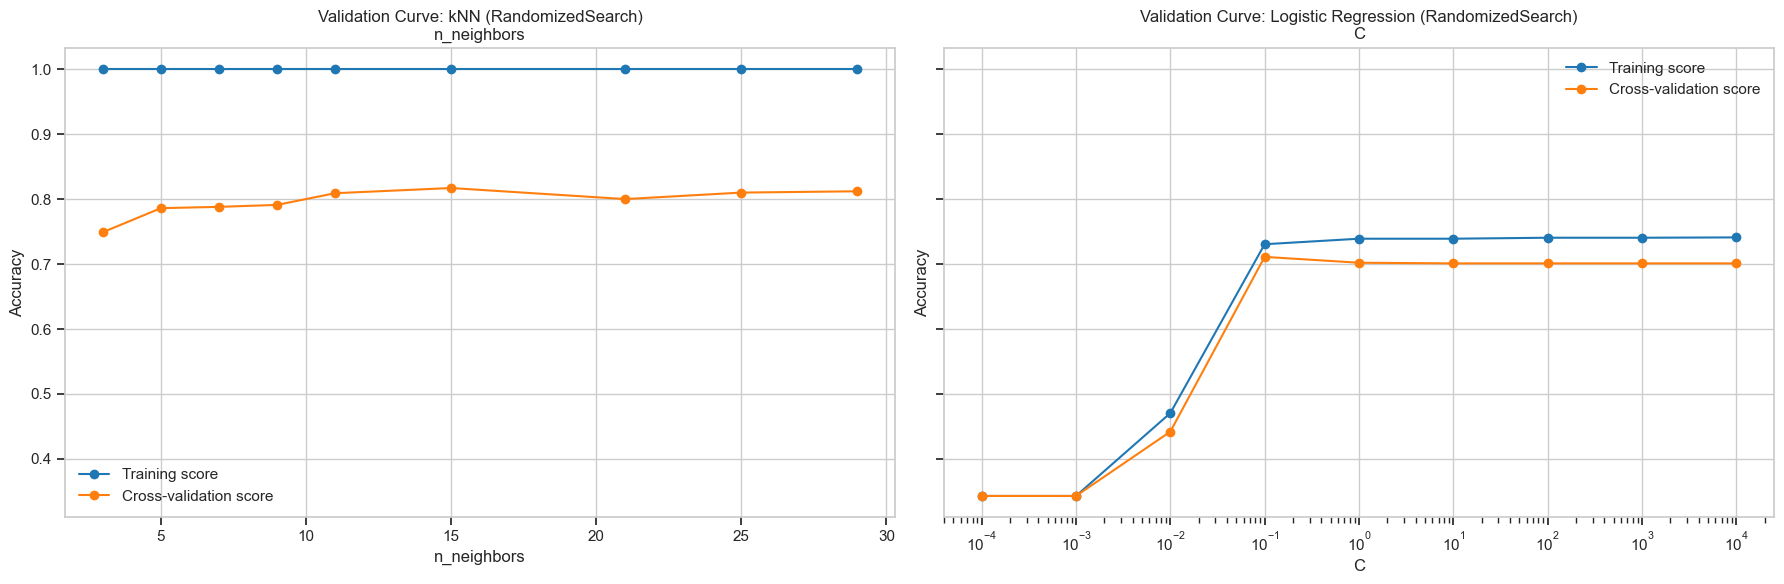

In [ ]:
# Extract actual values explored for each estimator
c_values_random = sorted(np.unique([p['logreg__C'] for p in random_search_logreg.cv_results_['params']]))
k_values_random = sorted(np.unique([p['knn__n_neighbors'] for p in random_search_knn.cv_results_['params']]))

# Only plot if both have at least 2 points (validation curve needs >1 point)
if len(c_values_random) > 1 and len(k_values_random) > 1:
    compare_validation_curves(
        random_search_knn.best_estimator_, random_search_logreg.best_estimator_,
        'kNN (RandomizedSearch)', 'Logistic Regression (RandomizedSearch)',
        'knn__n_neighbors', k_values_random,
        'logreg__C', c_values_random,
        X_train_val, y_train_val, cv=cv_inner
    )


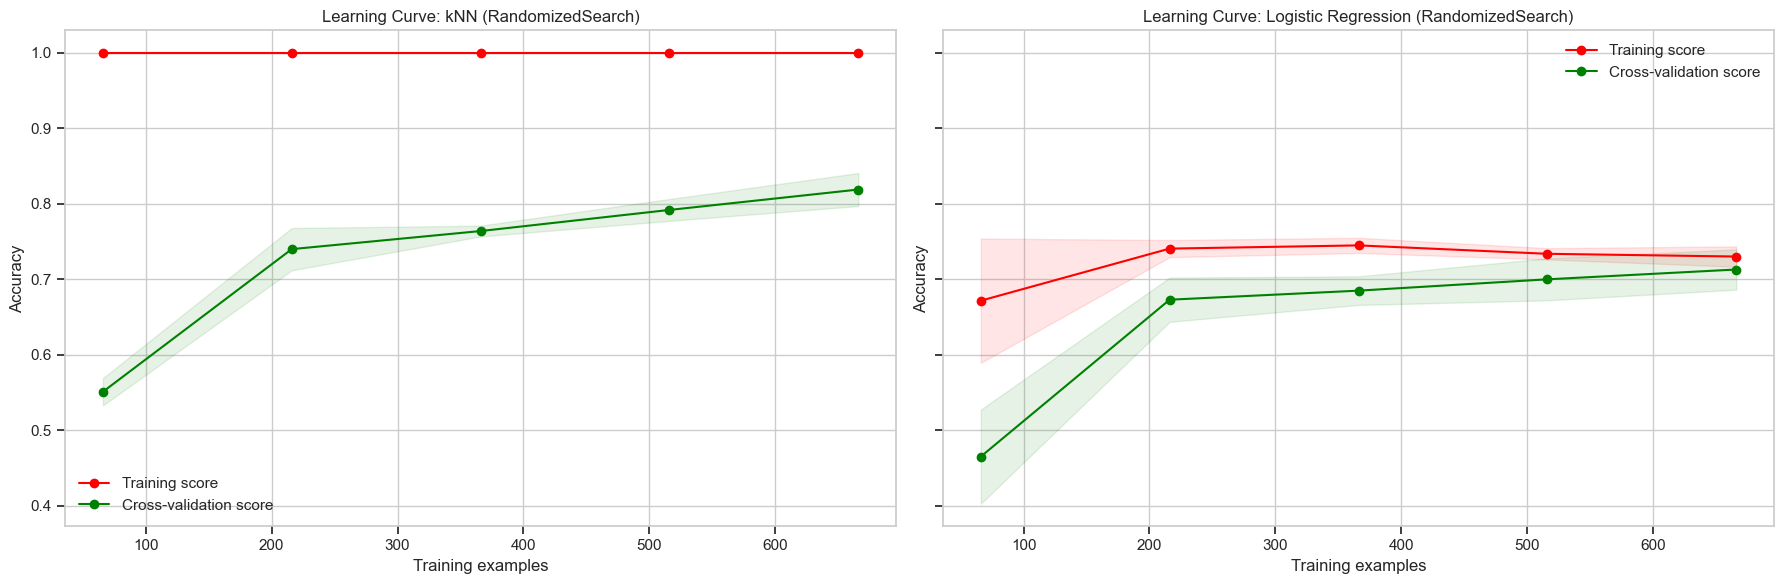

In [ ]:
compare_learning_curves(
    random_search_knn.best_estimator_, random_search_logreg.best_estimator_,
    'kNN (RandomizedSearch)', 'Logistic Regression (RandomizedSearch)',
    X_train_val, y_train_val, cv=cv_inner
)


### Halving Grid Search

In [ ]:
def safe_accuracy_scorer(estimator, X, y):
    try:
        n_neighbors = estimator.named_steps['knn'].n_neighbors
        if n_neighbors > len(X):
            return np.nan  # Penalizza configurazioni non valide
        return estimator.score(X, y)  # Usa accuracy default
    except Exception:
        return np.nan

halving_search_knn = HalvingGridSearchCV(knn_pipeline, knn_param_grid, cv=cv_inner,
                                         factor=3, scoring=safe_accuracy_scorer, random_state=RANDOM_STATE, n_jobs=-1)
start_time = time.perf_counter()
halving_search_knn.fit(X_train_val, y_train_val)
time_taken = time.perf_counter() - start_time
# n_candidates for HalvingGridSearchCV is more complex: sum over iterations.
# halving_search_knn.n_candidates_ # total candidates evaluated
results_summary.append({
    'model': 'kNN', 'strategy': 'HalvingGridSearchCV', 'time': time_taken, 'candidates': halving_search_knn.n_candidates_,
    'mean_score': halving_search_knn.best_score_, 'std_score': halving_search_knn.cv_results_['std_test_score'][halving_search_knn.best_index_],
    'best_params': halving_search_knn.best_params_
})
print(f"kNN HalvingGridSearchCV: Best Acc={halving_search_knn.best_score_:.4f}, Time={time_taken:.2f}s, Params={halving_search_knn.best_params_}")

kNN HalvingGridSearchCV: Best Acc=0.7459, Time=0.42s, Params={'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}


In [ ]:
halving_search_logreg = HalvingGridSearchCV(logreg_pipeline, logreg_param_grid, cv=cv_inner,
                                            factor=3, scoring='accuracy', random_state=RANDOM_STATE, n_jobs=-1)
start_time = time.perf_counter()
halving_search_logreg.fit(X_train_val, y_train_val)
time_taken = time.perf_counter() - start_time
results_summary.append({
    'model': 'LogReg', 'strategy': 'HalvingGridSearchCV', 'time': time_taken, 'candidates': halving_search_logreg.n_candidates_,
    'mean_score': halving_search_logreg.best_score_, 'std_score': halving_search_logreg.cv_results_['std_test_score'][halving_search_logreg.best_index_],
    'best_params': halving_search_logreg.best_params_
})

/Users/francescobraicovich/Documents/Python/Personale/parameter_optimization/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


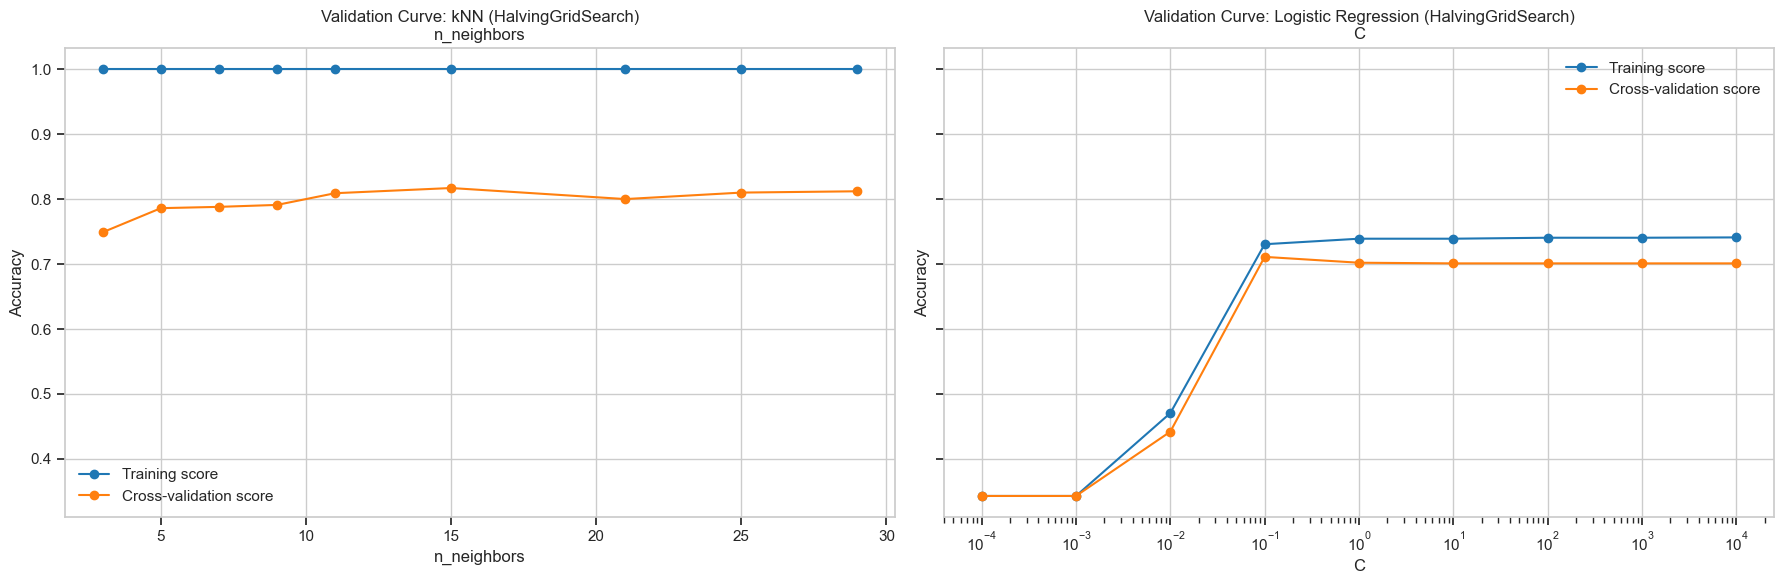

In [ ]:
compare_validation_curves(
    halving_search_knn.best_estimator_, halving_search_logreg.best_estimator_,
    'kNN (HalvingGridSearch)', 'Logistic Regression (HalvingGridSearch)',
    'knn__n_neighbors', knn_param_grid['knn__n_neighbors'],
    'logreg__C', logreg_param_grid['logreg__C'],
    X_train_val, y_train_val, cv=cv_inner
)

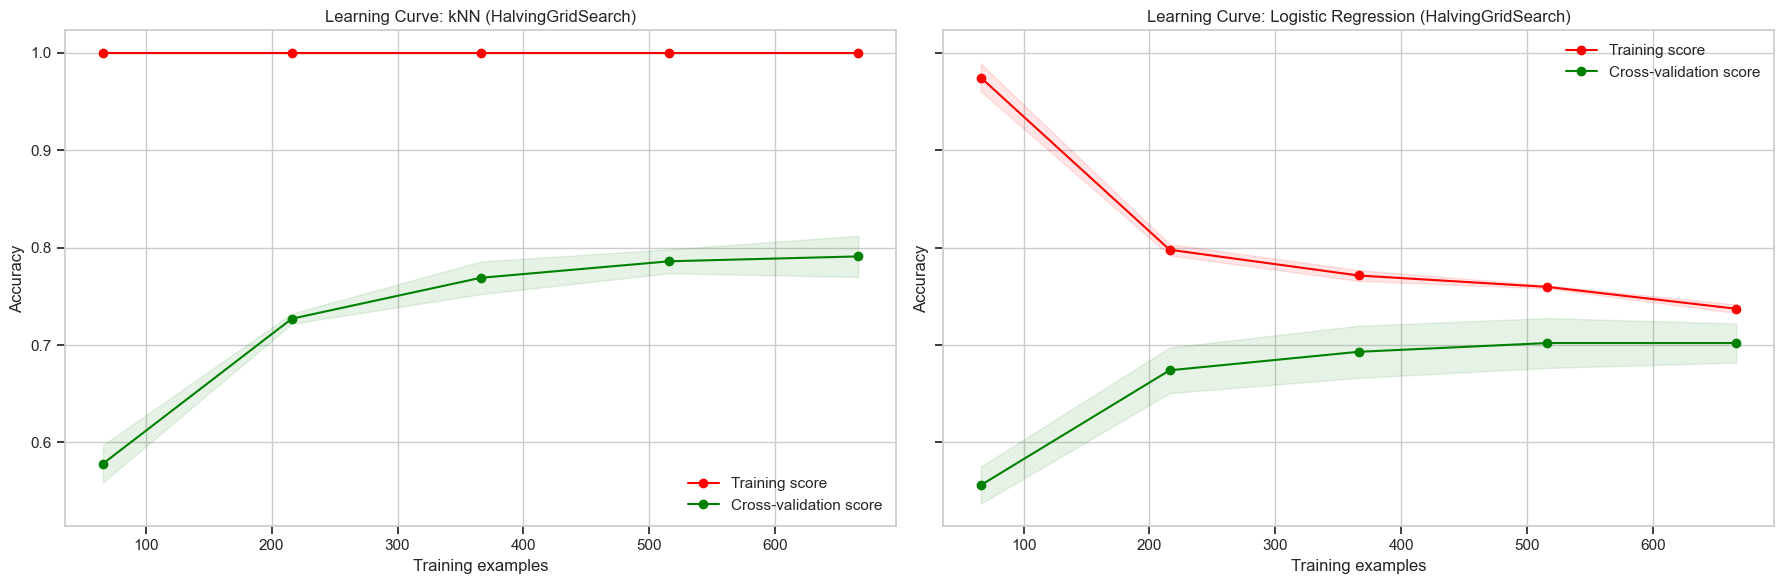

In [ ]:
compare_learning_curves(
    halving_search_knn.best_estimator_, halving_search_logreg.best_estimator_,
    'kNN (HalvingGridSearch)', 'Logistic Regression (HalvingGridSearch)',
    X_train_val, y_train_val, cv=cv_inner
)


### Optuna

In [ ]:
def suggest_from_param_grid_knn(trial, param_grid):
    params = {}

    for param, values in param_grid.items():
        if isinstance(values[0], str) or isinstance(values[0], bool):
            params[param] = trial.suggest_categorical(param, values)
        elif isinstance(values[0], int):
            if len(set(values)) <= 10:
                params[param] = trial.suggest_categorical(param, values)
            else:
                params[param] = trial.suggest_int(param, min(values), max(values))
        elif isinstance(values[0], float):
            params[param] = trial.suggest_float(param, min(values), max(values))
        else:
            raise ValueError(f"Unsupported type in grid for param: {param}")
    
    # Apply conditional logic: remove 'knn__p' unless metric is 'minkowski'
    if 'knn__p' in params and params.get('knn__metric') != 'minkowski':
        del params['knn__p']

    return params

In [ ]:
def optuna_objective_knn(trial):
    # Suggest params automatically
    params = suggest_from_param_grid_knn(trial, knn_param_grid)

    # Extract with fallback defaults
    n_neighbors = params['knn__n_neighbors']
    weights = params['knn__weights']
    metric = params['knn__metric']
    p_val = params.get('knn__p', 2)  # only used if minkowski

    model = Pipeline([
        ('scaler', scaler),
        ('knn', KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,
            metric=metric,
            p=p_val
        ))
    ])

    score = cross_val_score(model, X_train_val, y_train_val, cv=cv_inner, scoring='accuracy', n_jobs=-1).mean()
    return score

start_time = time.perf_counter()
optuna_study_knn = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
optuna_study_knn.optimize(optuna_objective_knn, n_trials=N_TRIALS_OPTUNA, n_jobs=-1) # n_jobs for parallel trials
time_taken = time.perf_counter() - start_time
optuna_best_params_knn = optuna_study_knn.best_params
# Reconstruct p for minkowski if needed for the final estimator
if 'knn__metric' in optuna_best_params_knn and optuna_best_params_knn['knn__metric'] != 'minkowski' and 'knn__p' in optuna_best_params_knn:
    del optuna_best_params_knn['knn__p'] # Clean up p if not minkowski
elif 'knn__metric' in optuna_best_params_knn and optuna_best_params_knn['knn__metric'] == 'minkowski' and 'knn__p' not in optuna_best_params_knn:
     optuna_best_params_knn['knn__p'] = 1 # default if not suggested but metric is minkowski

optuna_knn_estimator = Pipeline([('scaler', scaler), ('knn', KNeighborsClassifier(**{k.replace('knn__',''):v for k,v in optuna_best_params_knn.items()}))])

results_summary.append({
    'model': 'kNN', 'strategy': 'Optuna', 'time': time_taken, 'candidates': N_TRIALS_OPTUNA * N_CV_INNER,
    'mean_score': optuna_study_knn.best_value, 'std_score': np.nan, # Optuna study does not directly provide std of best score over folds
    'best_params': optuna_best_params_knn
})
print(f"kNN Optuna: Best Acc={optuna_study_knn.best_value:.4f}, Time={time_taken:.2f}s, Params={optuna_study_knn.best_params}")

kNN Optuna: Best Acc=0.8170, Time=0.34s, Params={'knn__n_neighbors': 15, 'knn__weights': 'distance', 'knn__metric': 'manhattan', 'knn__p': 1}


In [ ]:
def suggest_from_param_grid(trial, param_grid: dict):
    params = {}
    # 1) Suggest everything generically
    for name, values in param_grid.items():
        first = values[0]
        if isinstance(first, (str, bool)):
            params[name] = trial.suggest_categorical(name, values)
        elif isinstance(first, int):
            params[name] = trial.suggest_categorical(name, values)
        elif isinstance(first, float):
            params[name] = trial.suggest_float(name, min(values), max(values), log=True)
        else:
            raise ValueError(f"Unsupported type for {name}: {type(first)}")

    pen    = params['logreg__penalty']
    solver = params['logreg__solver']
    # 2) Prune unsupported penalty/solver combos
    # elasticnet only with saga
    if pen == 'elasticnet' and solver != 'saga':
        raise optuna.exceptions.TrialPruned()
    # l1 only with liblinear or saga
    if pen == 'l1' and solver not in ('liblinear', 'saga'):
        raise optuna.exceptions.TrialPruned()
    # none not with liblinear
    if pen == 'none' and solver == 'liblinear':
        raise optuna.exceptions.TrialPruned()
    # any other penalty combos (l2 with any solver above) are fine

    # 3) Drop l1_ratio unless elasticnet+saga
    if not (pen == 'elasticnet' and solver == 'saga'):
        params.pop('logreg__l1_ratio', None)

    # 4) Drop dual unless liblinear+l2
    #    If user grid included dual, only keep it for liblinear & penalty l2
    if not (solver == 'liblinear' and pen == 'l2'):
        params.pop('logreg__dual', None)

    return params

In [ ]:
def optuna_objective_logreg(trial):
    params = suggest_from_param_grid(trial, logreg_param_grid)
    # strip the prefix and pass to LogisticRegression
    lr_kwargs = {k.replace('logreg__', ''): v for k, v in params.items()}
    model = Pipeline([
        ('scaler', scaler),
        ('logreg', LogisticRegression(**lr_kwargs))
    ])
    return cross_val_score(
        model, X_train_val, y_train_val,
        cv=cv_inner, scoring='accuracy',
        n_jobs=-1, error_score='raise'
    ).mean()


start_time = time.perf_counter()
optuna_study_logreg = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
optuna_study_logreg.optimize(optuna_objective_logreg, n_trials=N_TRIALS_OPTUNA, n_jobs=-1)
time_taken = time.perf_counter() - start_time
best_raw = optuna_study_logreg.best_params
best_kwargs = {k.replace('logreg__', ''): v for k, v in best_raw.items()}
optuna_logreg_estimator = Pipeline([
    ('scaler', scaler),
    ('logreg', LogisticRegression(
        random_state=RANDOM_STATE,
        **best_kwargs
    ))
])
results_summary.append({
    'model': 'LogReg', 'strategy': 'Optuna', 'time': time_taken, 'candidates': N_TRIALS_OPTUNA * N_CV_INNER,
    'mean_score': optuna_study_logreg.best_value, 'std_score': np.nan,
    'best_params': optuna_study_logreg.best_params
})
print(f"LogReg Optuna: Best Acc={optuna_study_logreg.best_value:.4f}, Time={time_taken:.2f}s, Params={optuna_study_logreg.best_params}")

LogReg Optuna: Best Acc=0.7150, Time=0.41s, Params={'logreg__C': 0.18012802644880604, 'logreg__penalty': 'l1', 'logreg__max_iter': 10000, 'logreg__solver': 'saga'}


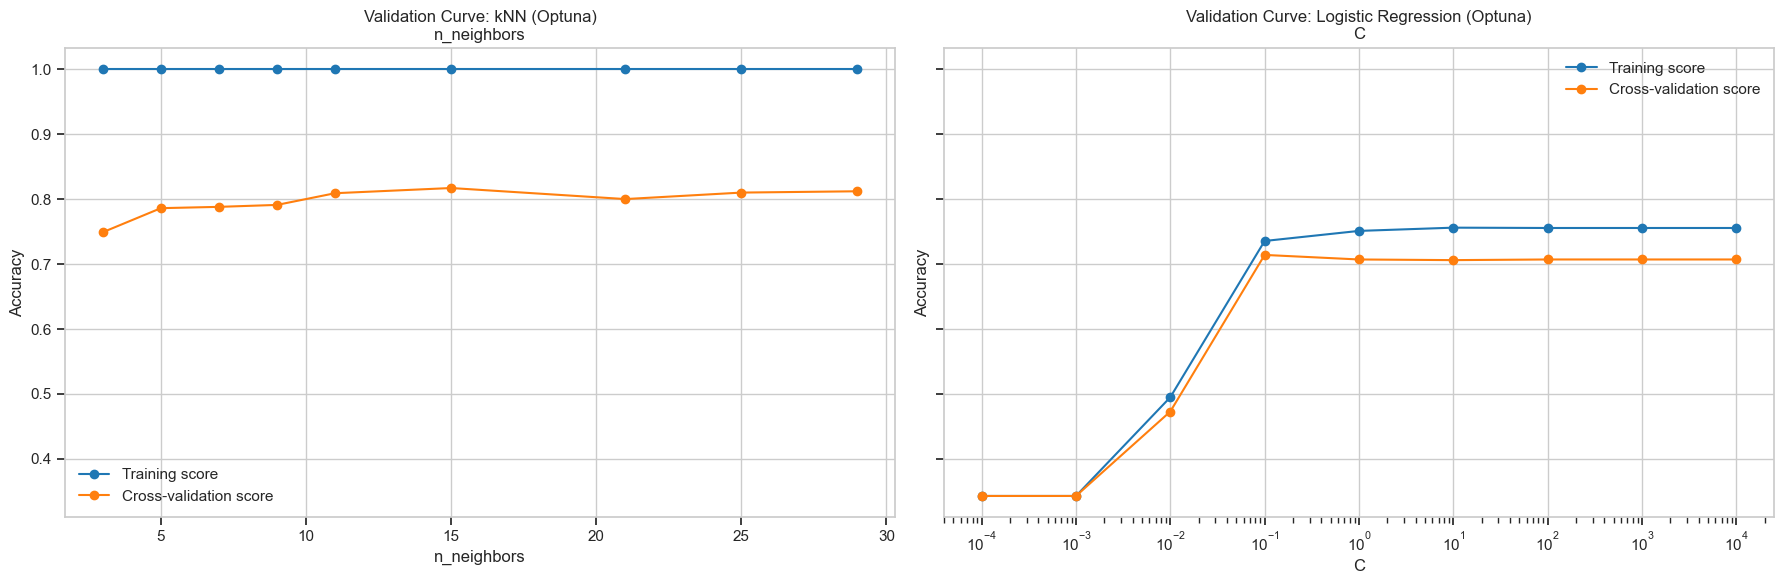

In [ ]:
compare_validation_curves(
    optuna_knn_estimator, optuna_logreg_estimator,
    'kNN (Optuna)', 'Logistic Regression (Optuna)',
    'knn__n_neighbors', knn_param_grid['knn__n_neighbors'],
    'logreg__C', np.logspace(-4, 4, 9),
    X_train_val, y_train_val, cv=cv_inner
)

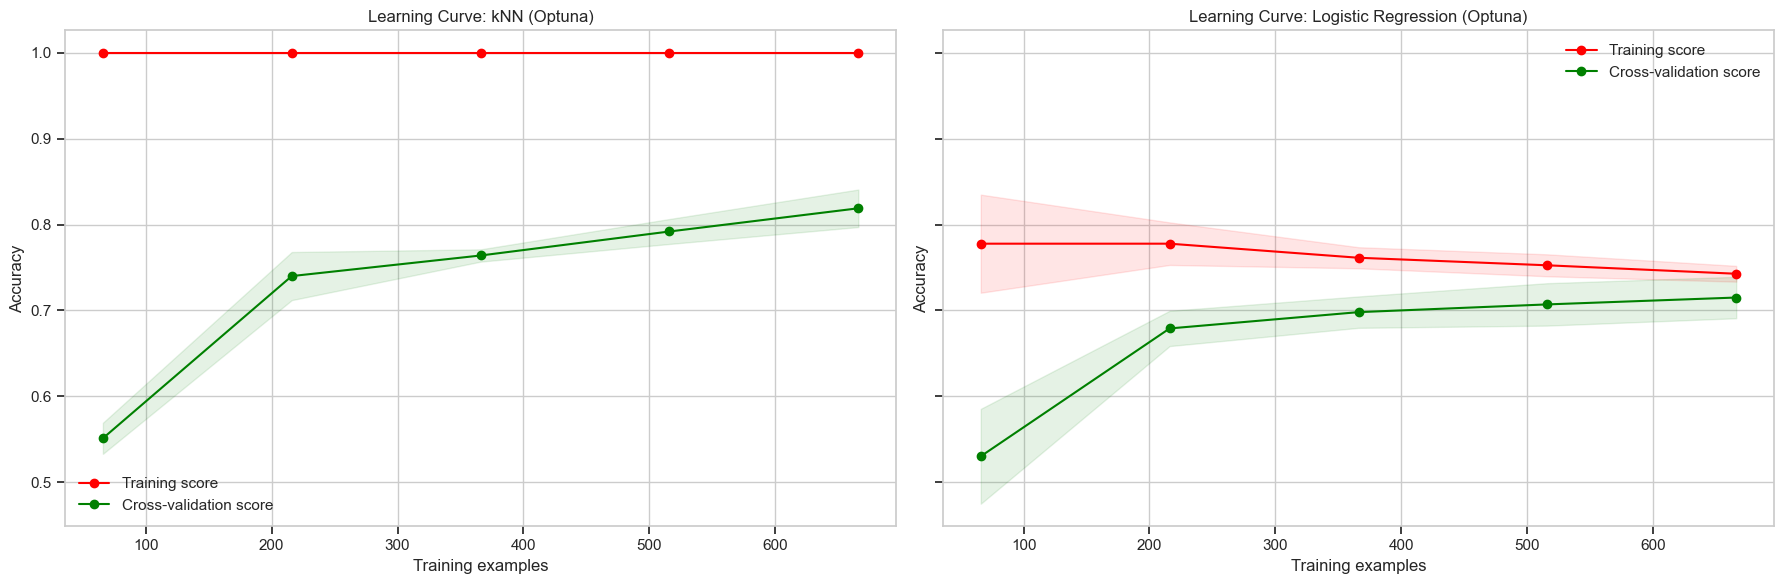

In [ ]:
compare_learning_curves(
    optuna_knn_estimator, optuna_logreg_estimator,
    'kNN (Optuna)', 'Logistic Regression (Optuna)',
    X_train_val, y_train_val, cv=cv_inner
)

### Bayes Search

In [ ]:
bayes_search_knn = BayesSearchCV(knn_pipeline, knn_search_spaces_skopt, n_iter=N_ITER_RANDOM,
                                 cv=cv_inner, scoring='accuracy', random_state=RANDOM_STATE, n_jobs=-1)
start_time = time.perf_counter()
bayes_search_knn.fit(X_train_val, y_train_val) # X, y
time_taken = time.perf_counter() - start_time
results_summary.append({
    'model': 'kNN', 'strategy': 'BayesSearchCV (skopt)', 'time': time_taken, 'candidates': N_ITER_RANDOM * N_CV_INNER,
    'mean_score': bayes_search_knn.best_score_, 'std_score': bayes_search_knn.cv_results_['std_test_score'][bayes_search_knn.best_index_],
    'best_params': bayes_search_knn.best_params_
})
print(f"kNN BayesSearchCV (skopt): Best Acc={bayes_search_knn.best_score_:.4f}, Time={time_taken:.2f}s, Params={bayes_search_knn.best_params_}")


kNN BayesSearchCV (skopt): Best Acc=0.8190, Time=20.77s, Params=OrderedDict({'knn__metric': 'manhattan', 'knn__n_neighbors': 14, 'knn__p': 1, 'knn__weights': 'distance'})


In [ ]:
bayes_search_logreg = BayesSearchCV(logreg_pipeline, logreg_search_spaces_skopt, n_iter=N_ITER_RANDOM,
                                   cv=cv_inner, scoring='accuracy', random_state=RANDOM_STATE, n_jobs=-1)
start_time = time.perf_counter()
bayes_search_logreg.fit(X_train_val, y_train_val)
time_taken = time.perf_counter() - start_time
results_summary.append({
    'model': 'LogReg', 'strategy': 'BayesSearchCV (skopt)', 'time': time_taken, 'candidates': N_ITER_RANDOM * N_CV_INNER,
    'mean_score': bayes_search_logreg.best_score_, 'std_score': bayes_search_logreg.cv_results_['std_test_score'][bayes_search_logreg.best_index_],
    'best_params': bayes_search_logreg.best_params_
})
print(f"LogReg BayesSearchCV (skopt): Best Acc={bayes_search_logreg.best_score_:.4f}, Time={time_taken:.2f}s, Params={bayes_search_logreg.best_params_}")


LogReg BayesSearchCV (skopt): Best Acc=0.7130, Time=16.70s, Params=OrderedDict({'logreg__C': 0.10684752740882134, 'logreg__penalty': 'l1'})


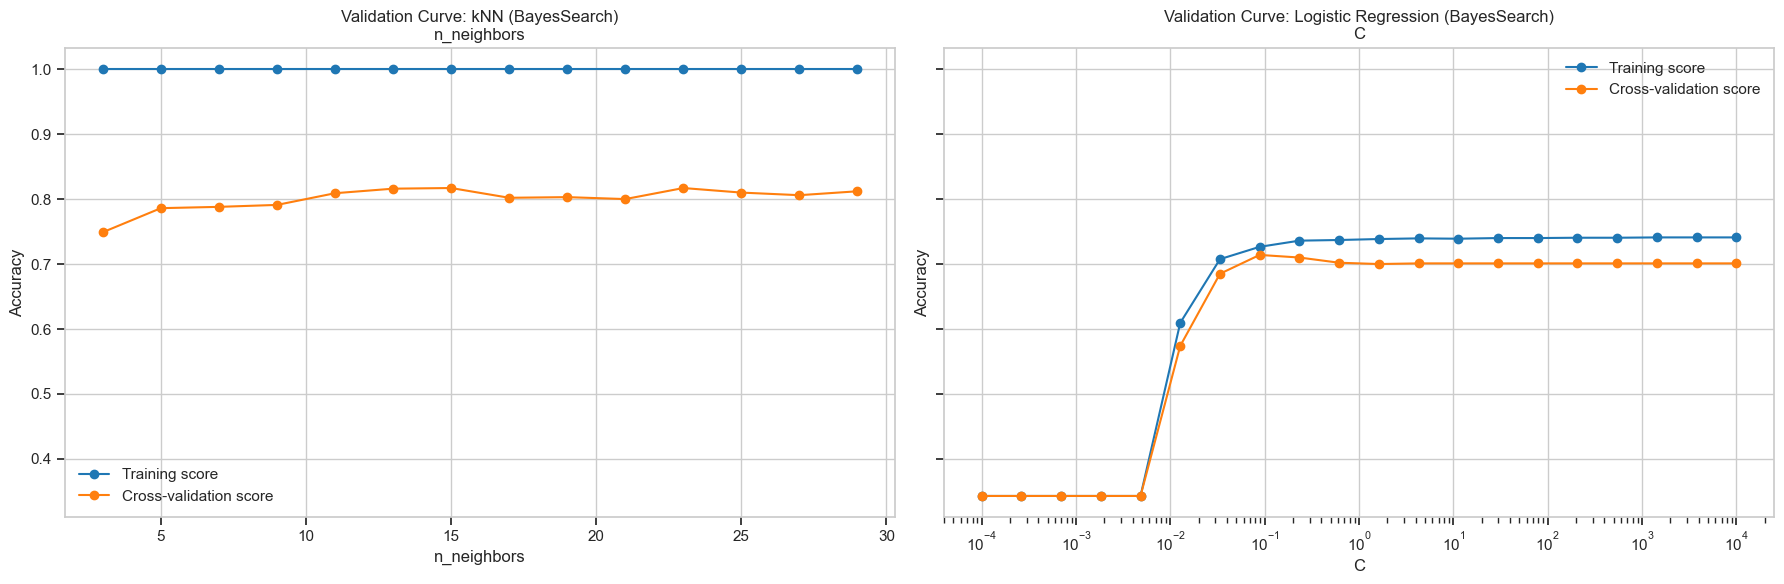

In [ ]:
compare_validation_curves(
    bayes_search_knn.best_estimator_, bayes_search_logreg.best_estimator_,
    'kNN (BayesSearch)', 'Logistic Regression (BayesSearch)',
    'knn__n_neighbors', list(range(3, 30, 2)),
    'logreg__C', np.logspace(-4, 4, 20),
    X_train_val, y_train_val, cv=cv_inner
)


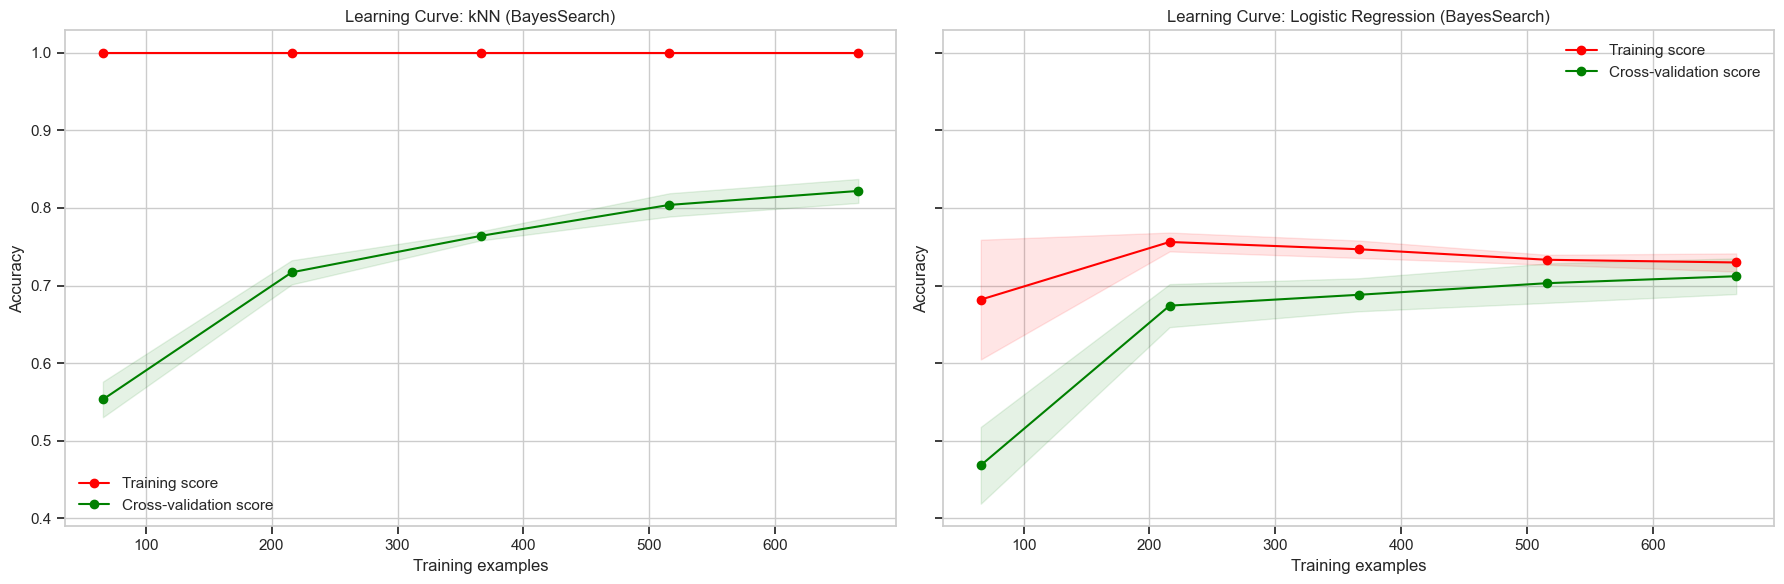

In [ ]:
compare_learning_curves(
    bayes_search_knn.best_estimator_, bayes_search_logreg.best_estimator_,
    'kNN (BayesSearch)', 'Logistic Regression (BayesSearch)',
    X_train_val, y_train_val, cv=cv_inner
)


### Performance vs. Tuning Time

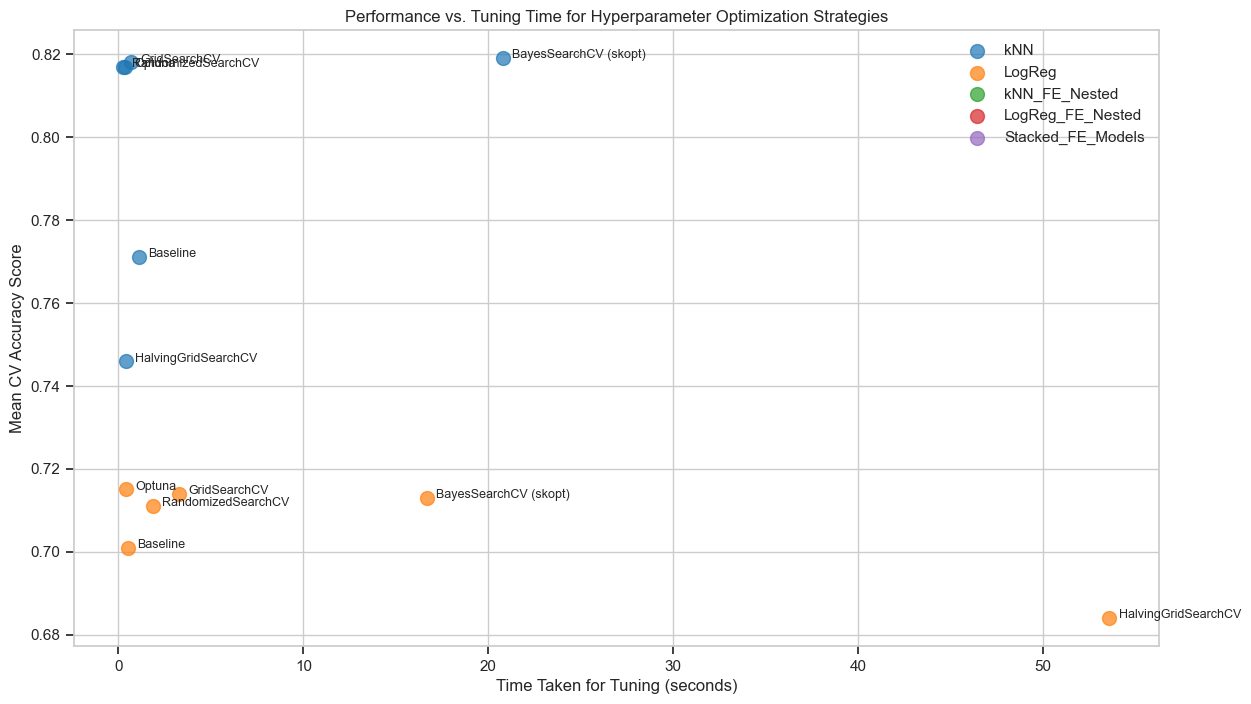


Summary of Hyperparameter Optimization Strategies:
            model              strategy   time       candidates  mean_score  std_score
           LogReg                Optuna  0.407              150       0.715        NaN
           LogReg          GridSearchCV  3.259              270       0.714      0.024
           LogReg BayesSearchCV (skopt) 16.699              150       0.713      0.023
           LogReg    RandomizedSearchCV  1.852              150       0.711      0.024
           LogReg              Baseline  0.514                1       0.701      0.025
           LogReg   HalvingGridSearchCV 53.588  [90, 30, 10, 4]       0.684      0.040
 LogReg_FE_Nested         Optuna_Nested    NaN              750       0.709      0.017
Stacked_FE_Models       Nested_CV_Stack    NaN                1       0.846      0.037
              kNN BayesSearchCV (skopt) 20.772              150       0.819      0.016
              kNN          GridSearchCV  0.708              324       0.818   

In [ ]:
results_df = pd.DataFrame(results_summary)

plt.figure(figsize=(14, 8))
for model_type in results_df['model'].unique():
    subset = results_df[results_df['model'] == model_type]
    plt.scatter(subset['time'], subset['mean_score'], label=model_type, s=100, alpha=0.7)
    for i, row in subset.iterrows():
        plt.text(row['time'] + 0.5, row['mean_score'], row['strategy'], fontsize=9)

plt.xlabel("Time Taken for Tuning (seconds)")
plt.ylabel("Mean CV Accuracy Score")
plt.title("Performance vs. Tuning Time for Hyperparameter Optimization Strategies")
plt.legend()
plt.grid(True)
# plt.xscale('log') # Optional: if times vary wildly
plt.show()

print("\nSummary of Hyperparameter Optimization Strategies:")
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)
print(
    results_df.drop(columns='best_params', errors='ignore')
    .sort_values(by=['model', 'mean_score'], ascending=[True, False])
    .round(3)
    .to_string(index=False)
)

## Ensemble Learning

### Feature Engineering

In [ ]:
def create_fe_pipeline(model_name, trial=None):
    # Feature Engineering steps to choose from / optimize
    poly_degree = 1 # Default to no polynomial features
    n_pca_components = None # Default to no PCA
    k_select_best = 'all' # Default to all features

    if trial: # If Optuna trial, suggest FE parameters
        use_poly = trial.suggest_categorical(f'fe_poly', [False, True])
        if use_poly:
            poly_degree = trial.suggest_int(f'fe_poly_degree', 2, 2) # Keep degree low (e.g., 2) due to 35 features

        use_pca = trial.suggest_categorical(f'fe_pca', [False, True])
        if use_pca:
            n_pca_components = trial.suggest_float(f'fe_pca_n_components', 0.85, 0.99)
        
        use_kbest = trial.suggest_categorical(f'fe_kbest', [False, True])
        if use_kbest:
             # Ensure k is not more than available features after previous steps.
             # This is complex to handle dynamically here, so assume it's applied on original features.
            k_select_best = trial.suggest_int(f'fe_kbest_k', 10, X_train_val.shape[1]) 
    
    # Build FE part of the pipeline
    feature_transformers = []
    if poly_degree > 1: # This will be PolynomialFeatures(degree=poly_degree)
        # Caution: PolynomialFeatures before PCA/SelectKBest can be problematic for n_features interpretation
        # Better to apply PolynomialFeatures on selected/reduced features, or select from polynomial features
        # For simplicity here, let's assume it's applied first if chosen.
        # This is a simplification; a more robust FE pipeline might use FeatureUnion or conditional steps
        pass # Will integrate polyfeatures later with FeatureUnion or careful ordering

    if n_pca_components:
        feature_transformers.append(('pca', PCA(n_components=n_pca_components, random_state=RANDOM_STATE)))
    if k_select_best != 'all' and isinstance(k_select_best, int):
         feature_transformers.append(('select_kbest', SelectKBest(f_classif, k=k_select_best)))


    # This basic FeatureUnion example doesn't dynamically handle poly features output well with kbest/pca
    # A simpler approach: select one FE method or none.
    fe_step = 'passthrough'
    if trial:
        fe_choice = trial.suggest_categorical('fe_choice', ['none', 'pca', 'kbest'])
        if fe_choice == 'pca':
            n_pca_components = trial.suggest_float('fe_pca_n_components_adv', 0.85, 0.99)
            fe_step = PCA(n_components=n_pca_components, random_state=RANDOM_STATE)
        elif fe_choice == 'kbest':
            k_select_best = trial.suggest_int('fe_kbest_k_adv', 10, X_train_val.shape[1])
            fe_step = SelectKBest(f_classif, k=k_select_best)

    # Model specific HPO
    if model_name == 'knn':
        n_neighbors = trial.suggest_int('knn_n_neighbors', 3, 29) if trial else 5
        weights = trial.suggest_categorical('knn_weights', ['uniform', 'distance']) if trial else 'uniform'
        metric = trial.suggest_categorical('knn_metric', ['euclidean', 'manhattan', 'minkowski']) if trial else 'euclidean'
        p_val = 1
        if metric == 'minkowski':
            p_val = trial.suggest_int('knn_p', 1, 2) if trial else 1
        classifier = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric, p=p_val)
    elif model_name == 'logreg':
        C = trial.suggest_float('logreg_C', 1e-4, 1e4, log=True) if trial else 1.0
        penalty = trial.suggest_categorical('logreg_penalty', ['l1', 'l2']) if trial else 'l2'
        classifier = LogisticRegression(C=C, penalty=penalty, solver='liblinear', random_state=RANDOM_STATE)
    else:
        raise ValueError("Unknown model name")

    return Pipeline([
        ('scaler', StandardScaler()),
        ('feature_engineering', fe_step), # Simplified FE choice
        (model_name, classifier)
    ])


### Optuna with Feature Engineering

In [ ]:
# Nested CV Objective for Optuna
def nested_cv_objective(trial, model_name):
    pipeline = create_fe_pipeline(model_name, trial)
    # Inner loop CV for HPO (Optuna does this implicitly by optimizing objective's return value)
    # The score here is already an average from cross_val_score
    return cross_val_score(pipeline, X_train_val, y_train_val, cv=cv_inner, scoring='accuracy', n_jobs=-1).mean()

In [ ]:
study_knn_fe = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_knn_fe.optimize(lambda trial: nested_cv_objective(trial, 'knn'), n_trials=N_TRIALS_OPTUNA, n_jobs=-1)
best_pipeline_knn_fe_outer_loop = create_fe_pipeline('knn', study_knn_fe.best_trial) # Using best trial params
nested_scores_knn_fe = cross_val_score(best_pipeline_knn_fe_outer_loop, X_train_val, y_train_val, cv=cv_outer, scoring='accuracy', n_jobs=-1)
print(f"kNN + FE (Nested CV & Optuna): Mean Acc={np.mean(nested_scores_knn_fe):.4f} +/- {np.std(nested_scores_knn_fe):.4f}")
print(f"Best Params: {study_knn_fe.best_params}")
results_summary.append({
    'model': 'kNN_FE_Nested', 'strategy': 'Optuna_Nested', 'time': None, # Time for outer loop eval, not full HPO search for each outer fold
    'candidates': N_TRIALS_OPTUNA * N_CV_INNER * N_CV_OUTER, # Approximation
    'mean_score': np.mean(nested_scores_knn_fe), 'std_score': np.std(nested_scores_knn_fe),
    'best_params': study_knn_fe.best_params
})

kNN + FE (Nested CV & Optuna): Mean Acc=0.8420 +/- 0.0391
Best Params: {'fe_poly': True, 'fe_poly_degree': 2, 'fe_pca': False, 'fe_kbest': False, 'fe_choice': 'kbest', 'fe_kbest_k_adv': 19, 'knn_n_neighbors': 17, 'knn_weights': 'distance', 'knn_metric': 'euclidean'}


In [ ]:
study_logreg_fe = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_logreg_fe.optimize(lambda trial: nested_cv_objective(trial, 'logreg'), n_trials=N_TRIALS_OPTUNA, n_jobs=-1)
best_pipeline_logreg_fe_outer_loop = create_fe_pipeline('logreg', study_logreg_fe.best_trial)
nested_scores_logreg_fe = cross_val_score(best_pipeline_logreg_fe_outer_loop, X_train_val, y_train_val, cv=cv_outer, scoring='accuracy', n_jobs=-1)
print(f"LogReg + FE (Nested CV & Optuna): Mean Acc={np.mean(nested_scores_logreg_fe):.4f} +/- {np.std(nested_scores_logreg_fe):.4f}")
print(f"Best Params: {study_logreg_fe.best_params}")
results_summary.append({
    'model': 'LogReg_FE_Nested', 'strategy': 'Optuna_Nested', 'time': None,
    'candidates': N_TRIALS_OPTUNA * N_CV_INNER * N_CV_OUTER, # Approximation
    'mean_score': np.mean(nested_scores_logreg_fe), 'std_score': np.std(nested_scores_logreg_fe),
    'best_params': study_logreg_fe.best_params
})

LogReg + FE (Nested CV & Optuna): Mean Acc=0.7090 +/- 0.0174
Best Params: {'fe_poly': False, 'fe_pca': True, 'fe_pca_n_components': 0.851413361581601, 'fe_kbest': True, 'fe_kbest_k': 24, 'fe_choice': 'none', 'logreg_C': 0.08355746173145409, 'logreg_penalty': 'l1'}


### Stacking Classifier

In [ ]:
best_knn_fe_config = study_knn_fe.best_trial
best_logreg_fe_config = study_logreg_fe.best_trial

# Re-create the pipelines with their best configurations
estimator_knn_for_stacking = create_fe_pipeline('knn', best_knn_fe_config)
estimator_logreg_for_stacking = create_fe_pipeline('logreg', best_logreg_fe_config)

base_estimators = [
    ('knn_fe', estimator_knn_for_stacking),
    ('logreg_fe', estimator_logreg_for_stacking)
]
# Meta-classifier
meta_classifier = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)

# Stacking pipeline
# Note: StackingClassifier internally uses cross_val_predict for out-of-fold predictions.
# The `cv` parameter in StackingClassifier is for this internal process.
stacking_clf = StackingClassifier(estimators=base_estimators, final_estimator=meta_classifier, cv=cv_inner, n_jobs=-1)

# Evaluate the StackingClassifier using the outer cross-validation loop
nested_scores_stacking = cross_val_score(stacking_clf, X_train_val, y_train_val, cv=cv_outer, scoring='accuracy', n_jobs=-1)
print(f"Stacked Classifier (kNN_FE, LogReg_FE) / LogReg_Meta (Nested CV): Mean Acc={np.mean(nested_scores_stacking):.4f} +/- {np.std(nested_scores_stacking):.4f}")
results_summary.append({
    'model': 'Stacked_FE_Models', 'strategy': 'Nested_CV_Stack', 'time': None,
    'candidates': 1, # Evaluates one stacking configuration
    'mean_score': np.mean(nested_scores_stacking), 'std_score': np.std(nested_scores_stacking),
    'best_params': {'knn_params': study_knn_fe.best_params, 'logreg_params': study_logreg_fe.best_params}
})


Stacked Classifier (kNN_FE, LogReg_FE) / LogReg_Meta (Nested CV): Mean Acc=0.8460 +/- 0.0368


In [ ]:
print("\n\n--- Final Model Selection ---")
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

final_results_df = pd.DataFrame(results_summary)
print("\nOverall Summary of All Models and Strategies (Sorted by Mean Score):")
final_results_df_sorted = print(
    final_results_df.drop(columns='best_params', errors='ignore')
    .sort_values(by=['model', 'mean_score'], ascending=[True, False])
    .round(3)
    .to_string(index=False)
)
print(final_results_df_sorted)

best_overall_model_config = final_results_df_sorted.iloc[0]
print(f"\nBest overall configuration based on CV mean score: {best_overall_model_config['model']} with strategy {best_overall_model_config['strategy']}")
print(f"Achieved Mean CV Score: {best_overall_model_config['mean_score']:.4f}")
print(f"Parameters/Configuration: {best_overall_model_config['best_params']}")

final_selected_model = None
if best_overall_model_config['model'] == 'Stacked_FE_Models':
    # Re-create the best base estimators for the stack
    final_knn_for_stacking = create_fe_pipeline('knn', optuna.trial.FixedTrial(best_overall_model_config['best_params']['knn_params']))
    final_logreg_for_stacking = create_fe_pipeline('logreg', optuna.trial.FixedTrial(best_overall_model_config['best_params']['logreg_params']))
    final_base_estimators = [('knn_fe', final_knn_for_stacking), ('logreg_fe', final_logreg_for_stacking)]
    final_selected_model = StackingClassifier(estimators=final_base_estimators, 
                                            final_estimator=LogisticRegression(solver='liblinear', random_state=RANDOM_STATE), 
                                            cv=cv_inner, n_jobs=-1)
elif best_overall_model_config['model'] == 'kNN_FE_Nested':
    final_selected_model = create_fe_pipeline('knn', optuna.trial.FixedTrial(best_overall_model_config['best_params']))
elif best_overall_model_config['model'] == 'LogReg_FE_Nested':
    final_selected_model = create_fe_pipeline('logreg', optuna.trial.FixedTrial(best_overall_model_config['best_params']))
else: # Fallback to one of the simpler HPO strategies if they topped the list (e.g. Optuna on base features)
    model_type = best_overall_model_config['model']
    params = best_overall_model_config['best_params']
    if model_type == 'kNN':
        final_selected_model = Pipeline([('scaler', scaler), ('knn', KNeighborsClassifier(**{k.replace('knn__',''):v for k,v in params.items()}))])
    elif model_type == 'LogReg':
        final_selected_model = Pipeline([('scaler', scaler), ('logreg', LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, **{k.replace('logreg__',''):v for k,v in params.items()}))])


if final_selected_model:
    print(f"\nTraining chosen model ({best_overall_model_config['model']}) on full X_train_val set...")
    final_selected_model.fit(X_train_val, y_train_val)
    
    print("\nEvaluating on Test Set...")
    y_pred_test = final_selected_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1_macro = f1_score(y_test, y_pred_test, average='macro')

    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score (Macro): {test_f1_macro:.4f}")
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred_test))
    
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.sort(y.unique()), yticklabels=np.sort(y.unique()))
    plt.title('Confusion Matrix (Test Set)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("\nCould not automatically determine the final model for test set evaluation.")



--- Final Model Selection ---

Overall Summary of All Models and Strategies (Sorted by Mean Score):
            model              strategy   time       candidates  mean_score  std_score
           LogReg                Optuna  0.407              150       0.715        NaN
           LogReg          GridSearchCV  3.259              270       0.714      0.024
           LogReg BayesSearchCV (skopt) 16.699              150       0.713      0.023
           LogReg    RandomizedSearchCV  1.852              150       0.711      0.024
           LogReg              Baseline  0.514                1       0.701      0.025
           LogReg   HalvingGridSearchCV 53.588  [90, 30, 10, 4]       0.684      0.040
 LogReg_FE_Nested         Optuna_Nested    NaN              750       0.709      0.017
Stacked_FE_Models       Nested_CV_Stack    NaN                1       0.846      0.037
              kNN BayesSearchCV (skopt) 20.772              150       0.819      0.016
              kNN          G

AttributeError: 'NoneType' object has no attribute 'iloc'